# Package Requirements

In [ ]:
!pip install -q zstandard emoji
!pip install -q ipython==7.34.0
!pip install -q umap
!pip install -q accelerate
!pip install -qU bertopic
!pip install -qU hdbscan
!pip install -qU sentence-transformers
!pip install -qU transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.7/268.7 kB 13.8 MB/s eta 0:00:00


In [ ]:
import logging
import pandas as pd
import numpy as np
from datetime import datetime
import zstandard as zstd
import json
import re
import os
import nltk
from nltk.corpus import stopwords
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stop_words
from collections import Counter
import emoji
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from textblob import TextBlob
import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Top 10 Popular Kpop Group Names

In [ ]:
!pip install --upgrade -q gdown

In [ ]:
!gdown "https://docs.google.com/spreadsheets/d/1SiNTBVB6Ax5Q0fa6py7shTQxjkt1oPfxVspfSQUZmmo/export?format=xlsx" --fuzzy -O kpop_group_names.xlsx

Downloading...
From: https://docs.google.com/spreadsheets/d/1SiNTBVB6Ax5Q0fa6py7shTQxjkt1oPfxVspfSQUZmmo/export?format=xlsx
To: /content/kpop_group_names.xlsx
40.9kB [00:00, 701kB/s]


In [ ]:
names_data = pd.read_excel('kpop_group_names.xlsx')
columns = ['Official_eng','Official_kor','Others_eng','Others_kor']
group_names = names_data[columns]
group_names

,Official_eng,Official_kor,Others_eng,Others_kor
0,BTS,방탄소년단,"Bangtan, BangtanBoys, BangtanSonyeondan","방탄, 탄이들"
1,EXO,엑소,NaN,NaN
2,Seventeen,세븐틴,SVT,"셉, 셉틴"
3,Twice,트와이스,NaN,"트와, 트둥"
4,Blackpink,블랙핑크,"BP, Black pink",블핑
5,AESPA,에스파,NaN,짱스파
6,IVE,아이브,NaN,NaN
7,NCT Dream,엔시티드림,"Dream, Dreamies, 7Dream, nctdream","드림이, 드리미, 칠드림"
8,Red Velvet,레드벨벳,"RV, Redvelvet",레벨
9,Stray Kids,스트레이키즈,"SKZ, straykids","스키즈, 슼, 슼즈"


In [ ]:
group_names_dict = {}
for index, row in group_names.iterrows():
    values = []
    for item in row[1:]:
        if pd.notna(item):
            if isinstance(item, str):
                values.extend([val.strip() for val in item.split(',')])
    group_names_dict[row['Official_eng']] = values
group_names_dict

{'BTS': ['방탄소년단', 'Bangtan', 'BangtanBoys', 'BangtanSonyeondan', '방탄', '탄이들'],
 'EXO': ['엑소'],
 'Seventeen': ['세븐틴', 'SVT', '셉', '셉틴'],
 'Twice': ['트와이스', '트와', '트둥'],
 'Blackpink': ['블랙핑크', 'BP', 'Black pink', '블핑'],
 'AESPA': ['에스파', '짱스파'],
 'IVE': ['아이브'],
 'NCT Dream': ['엔시티드림',
  'Dream',
  'Dreamies',
  '7Dream',
  'nctdream',
  '드림이',
  '드리미',
  '칠드림'],
 'Red Velvet': ['레드벨벳', 'RV', 'Redvelvet', '레벨'],
 'Stray Kids': ['스트레이키즈', 'SKZ', 'straykids', '스키즈', '슼', '슼즈']}

In [ ]:
group_names_list = [item.strip() for col in group_names.columns for row in group_names[col].dropna() for item in str(row).split(',')]
group_names_list

['BTS',
 'EXO',
 'Seventeen',
 'Twice',
 'Blackpink',
 'AESPA',
 'IVE',
 'NCT Dream',
 'Red Velvet',
 'Stray Kids',
 '방탄소년단',
 '엑소',
 '세븐틴',
 '트와이스',
 '블랙핑크',
 '에스파',
 '아이브',
 '엔시티드림',
 '레드벨벳',
 '스트레이키즈',
 'Bangtan',
 'BangtanBoys',
 'BangtanSonyeondan',
 'SVT',
 'BP',
 'Black pink',
 'Dream',
 'Dreamies',
 '7Dream',
 'nctdream',
 'RV',
 'Redvelvet',
 'SKZ',
 'straykids',
 '방탄',
 '탄이들',
 '셉',
 '셉틴',
 '트와',
 '트둥',
 '블핑',
 '짱스파',
 '드림이',
 '드리미',
 '칠드림',
 '레벨',
 '스키즈',
 '슼',
 '슼즈']

# Archived Reddit Data (2012~2022)

File extension : .zst

File size : Submission - 138m / Comments - 505m

In [ ]:
# !gdown https://drive.google.com/uc?id=1hCEFY52ES8XM4WDXrYmbpJ4WETFt2rjH
# !gdown https://drive.google.com/uc?id=17NWZLse-ajk6ptsxaCZClcYlEzn3wdw0

In [ ]:
zst_submissions = '/content/drive/MyDrive/Master_Thesis/Data/kpop_submissions.zst'
zst_comments = '/content/drive/MyDrive/Master_Thesis/Data/kpop_comments.zst'

## Reddit Posts

In [ ]:
import io

start_date = datetime(2012, 1, 1).timestamp()
end_date = datetime(2022, 12, 31).timestamp()

columns_needed = ['id', 'title', 'selftext', 'num_comments', 'score', 'created_utc']

data_list = []
total_lines = 0

dctx = zstd.ZstdDecompressor()

with open(zst_submissions, 'rb') as compressed:
    with dctx.stream_reader(compressed) as reader:
        text_stream = io.TextIOWrapper(reader, encoding='utf-8')
        for line in text_stream:
            total_lines += 1
            data = json.loads(line)
            created_utc = int(data.get('created_utc', 0))
            if start_date <= created_utc <= end_date and data.get('selftext') not in ["[deleted]", "", "[removed]"] and data.get('title') not in ["[deleted by user]"]:
                row_data = {col: data.get(col, None) for col in columns_needed}
                data_list.append(row_data)

kpop_posts = pd.DataFrame(data_list)
print(f'The number of posts : {len(kpop_posts)}')
kpop_posts['created_utc'] = kpop_posts['created_utc'].astype(int)
kpop_posts_sorted_by_date = kpop_posts.sort_values(by="created_utc", ascending=True).reset_index(drop=True)
print(f"The date of the last post : {datetime.utcfromtimestamp(kpop_posts_sorted_by_date['created_utc'].iloc[-1]).strftime('%Y-%m-%d %H:%M:%S')}")
kpop_posts_sorted_by_date[-11:-1]

The number of posts : 25238
The date of the last post : 2022-12-30 15:17:05


,id,title,selftext,num_comments,score,created_utc
25227,zveu5q,/r/kpop Top Ten Tuesdays Results Thread: BTS (...,Inspired by [r/indieheads](https://www.reddit....,17,45,1672028388
25228,zviaq1,"Weekly Discussion (Dec 26, 2022 – Jan 1, 2023)",Welcome to r/kpop's [Weekly Discussion](https:...,1,19,1672041613
25229,zvj6eo,SMTOWN - 2022 Winter SMTOWN : SMCU PALACE (Spe...,[Album Cover](https://preview.redd.it/yryayilf...,95,446,1672045200
25230,zw0v0z,2022 Christmas Greetings &amp; Content Compila...,Hey everyone!\n\nI am back with a festive spec...,8,98,1672099053
25231,zw6ksb,Yerin Baek North American Tour - Appreciation ...,An announcement for Yerin Baek's North America...,47,213,1672115345
25232,zw81qc,/r/kpop Top Ten Tuesdays Voting Thread: Schedu...,Inspired by [r/indieheads](https://www.reddit....,89,67,1672119978
25233,zx42r0,"What Are You Listening To? - December 28, 2022",Share and discuss what you have been listening...,28,27,1672214710
25234,zx553j,WayV - Phantom (4th Mini Album),#[WayV - Phantom](https://preview.redd.it/51e8...,42,307,1672218825
25235,zy8cso,Mnet Boys Planet - Profiles,#K-Group\n\nName | Agency | Twitter Profile | ...,201,333,1672328524
25236,zyrj8a,ATEEZ - SPIN OFF : FROM THE WITNESS (1st Singl...,#[ATEEZ - SPIN OFF : FROM THE WITNESS](https:/...,30,182,1672376417


## Reddit Comments

In [ ]:
columns_needed = ['link_id', 'body']

data_list = []

dctx = zstd.ZstdDecompressor()
with open(zst_comments, 'rb') as compressed:
    with dctx.stream_reader(compressed) as reader:
        text_stream = io.TextIOWrapper(reader, encoding='utf-8')
        for line in text_stream:
            data = json.loads(line)
            created_utc = int(data.get('created_utc', 0))
            if start_date <= created_utc <= end_date and data.get('body') not in ["[deleted]", "", "[removed]"]:
                row_data = {col: data.get(col) for col in columns_needed}
                data_list.append(row_data)

kpop_comments = pd.DataFrame(data_list)
print(f'The number of comments : {len(kpop_comments)}')
kpop_comments[-11:-1]

The number of comments : 4576904


,link_id,body
4576893,t3_zzayj1,I hope they didn't include Heal by The Rose in...
4576894,t3_zz9vr8,"Congrats to her! She can sing, she can dance, ..."
4576895,t3_zz0dhx,"My queen Sooyoung deserves the world :,)"
4576896,t3_zzayj1,So happy to see MCND on there and especially C...
4576897,t3_zy8cso,"Cravity is almost 3 years into their career, i..."
4576898,t3_zyux7r,A big ol' F for YG accountants
4576899,t3_zz8lgd,"Nah uh, this is too much 😭😭"
4576900,t3_zyodya,I don’t know if yg will be willing to cooperat...
4576901,t3_zyz8ae,Mariah Carey sunbaenim is nowhere to be found....
4576902,t3_zzayj1,love to see stayc's young-luv here! easily my ...


## Merge : Post + Comments
Posts ['id'] + Comments['link_id'] after removing 't3_'

In [ ]:
kpop_comments['post_id'] = kpop_comments['link_id'].str[3:]
comments_agg = kpop_comments.groupby('post_id')['body'].agg(list).reset_index()
kpop_data = pd.merge(kpop_posts_sorted_by_date, comments_agg, left_on='id', right_on='post_id', how='left')
kpop_data = kpop_data.drop(columns=['post_id'], axis=1)
kpop_data['date'] = pd.to_datetime(kpop_data['created_utc'], unit='s').dt.strftime('%Y-%m-%d')
kpop_data = kpop_data.rename(columns={'selftext': 'body', 'body': 'comments'}).drop(columns=['created_utc'], axis=1)
print(f'The final dataset size : {len(kpop_data)}')
kpop_data[-11:-1]

The final dataset size : 25238


,id,title,body,num_comments,score,comments,date
25227,zveu5q,/r/kpop Top Ten Tuesdays Results Thread: BTS (...,Inspired by [r/indieheads](https://www.reddit....,17,45,[Full results:\n\n|Rank|Points|Title|Count|Per...,2022-12-26
25228,zviaq1,"Weekly Discussion (Dec 26, 2022 – Jan 1, 2023)",Welcome to r/kpop's [Weekly Discussion](https:...,1,19,[Just discovered [Bibi's Kazino](https://youtu...,2022-12-26
25229,zvj6eo,SMTOWN - 2022 Winter SMTOWN : SMCU PALACE (Spe...,[Album Cover](https://preview.redd.it/yryayilf...,95,446,"[Where’s the album on Spotify, SM?, Been looki...",2022-12-26
25230,zw0v0z,2022 Christmas Greetings &amp; Content Compila...,Hey everyone!\n\nI am back with a festive spec...,8,98,[Hi everyone! I know there a few artists perha...,2022-12-26
25231,zw6ksb,Yerin Baek North American Tour - Appreciation ...,An announcement for Yerin Baek's North America...,47,213,[I went to the [Houston date](https://streamab...,2022-12-27
25232,zw81qc,/r/kpop Top Ten Tuesdays Voting Thread: Schedu...,Inspired by [r/indieheads](https://www.reddit....,89,67,[1. JYP\n2. Winner\n3. Super Junior\n4. Psy\n5...,2022-12-27
25233,zx42r0,"What Are You Listening To? - December 28, 2022",Share and discuss what you have been listening...,28,27,[[I'm Gonna Love You](https://youtu.be/0El7H0S...,2022-12-28
25234,zx553j,WayV - Phantom (4th Mini Album),#[WayV - Phantom](https://preview.redd.it/51e8...,42,307,"[I love good life so much, Good Life is so goo...",2022-12-28
25235,zy8cso,Mnet Boys Planet - Profiles,#K-Group\n\nName | Agency | Twitter Profile | ...,201,333,"[have some trainees left already?, There is a ...",2022-12-29
25236,zyrj8a,ATEEZ - SPIN OFF : FROM THE WITNESS (1st Singl...,#[ATEEZ - SPIN OFF : FROM THE WITNESS](https:/...,30,182,"[HALAZIA SOUNDS AMAZING IM CRYING, I'm going t...",2022-12-30


In [ ]:
sum(kpop_data['num_comments'])

1306178

In [ ]:
kpop_data.to_csv('/content/drive/MyDrive/Master_Thesis/Data/kpop_data.csv', index=False)

# Data preprocessing

1. Text Preprocessing

    (1) Convert into Lowercase

    (2) URL Removal

    (3) Convert Emoji into a word for Sentiment Analysis

    (4) Special Symbols Removal except 'mention @' and 'hashtag #'

    (5) Stopwords
    
    (6) Customization : Missing apostrophe (common on internet)

    (7) Korean names : I want to keep it but
  
      * (6.1) The tools I am using in the study work for English only

      * (6.2) I have little reliability on Korean handling tools

      * (6.3) Using two different language tools increase unpredictable/unintended outcome
      * (6.4) But I keep group names in Korean to filter the relevant posts
2. Data Filtering with the group names (Complete word matching)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
nltk.download('stopwords')
nltk_stop_words = set(stopwords.words('english'))
spacy_stop_words = stop_words
combined_stopwords = spacy_stop_words.union(nltk_stop_words)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner','lemmatizer'])
#nlp.enable_pipe('tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def expand_contractions(text):
    contractions = {
        r"n't": " not",
        r"isnt": "is not",
        r"dont": "do not",
        r"doesnt": "does not",
        r"didnt": "did not",
        r"arent": "are not",
        r"wont": "will not",
        r"cant": "cannot",
        r"couldnt": "could not",
        r"shouldnt": "should not",
        r"wouldnt": "would not",
        r"werent": "were not",
        r"'re": " are",
        r"'d": " would",
        r"'ll": " will",
        r"'m": " am",
        r"y'all": "you all"
    }
    for key, value in contractions.items():
        text = re.sub(key, value, text)
    return text

def preprocess(text):
    text = expand_contractions(text)
    text = re.sub(r"\bi've\b", '', text, flags=re.IGNORECASE) # Exception : 'IVE' group --> [I've] manual deletion
    text = re.sub(r'(?<!^)\bDream\b', 'UNIQUEPLACEHOLDER', text)
    text = text.lower()
    text = re.sub(r"\b(ive)\b", "IVE", text, flags=re.IGNORECASE)
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # URL remova
    text = emoji.demojize(text, delimiters=(" ", " ")) # Convert emojis into words
    text = re.sub(r'[^#@a-zA-Z0-9\s]', '', text) # Remove special symbols except #, @
    text = re.sub(r'\s+', ' ', text).strip() # Replace multiple spaces with a single space
    text = re.sub(r"\bnt\b", '', text, flags=re.IGNORECASE) # Exception : 'nt' --> deletion
    text = re.sub(r'\buniqueplaceholder\b', 'Dream', text, flags=re.IGNORECASE)
    doc = nlp(text)

    tokens = []
    for token in doc:
        if token.text not in combined_stopwords :
          if token.text == 'Dream' and token.text[0].isupper():
              tokens.append('NCT Dream')
          elif token.text == 'like' and token.pos_ != 'VERB':
              continue
          else:
              tokens.append(token.text)

    text = ' '.join([word for word in tokens])
    return text

In [ ]:
test = "Dream it isnt true dream Dream"
print(preprocess(test))

dream true dream NCT Dream


In [ ]:
#kpop_data_processed = kpop_data.copy()

In [ ]:
# kpop_data_processed['title'] = kpop_data['title'].apply(preprocess)
# kpop_data_processed['body'] = kpop_data['body'].apply(preprocess)
# kpop_data_processed['comments'] = kpop_data['comments'].apply(
#     lambda x: [preprocess(comment) for comment in x] if isinstance(x, list) else x)

In [ ]:
#kpop_data_processed.to_pickle('/content/drive/MyDrive/Master_Thesis/Data/kpop_data_processed.pkl')

#Processed Data Load




In [ ]:
kpop_data_processed = pd.read_pickle('/content/drive/MyDrive/Master_Thesis/Data/kpop_data_processed.pkl')

In [ ]:
print(f'The number of posts : {len(kpop_data_processed)}')
kpop_data_processed[-11:-1]

The number of posts : 25238


,id,title,body,num_comments,score,comments,date
25227,zveu5q,rkpop tuesdays results thread bts 2022,inspired rindieheads rhiphopheads amp#x200b rk...,17,45,[results rankpointstitlecountpercentageaverage...,2022-12-26
25228,zviaq1,weekly discussion dec 26 2022 jan 1 2023,welcome rkpops weekly discussion post discuss ...,1,19,[discovered bibis kazino week good lord track ...,2022-12-26
25229,zvj6eo,smtown 2022 winter smtown smcu palace special ...,album cover smtown 2022 winter smtown smcu pal...,95,446,"[album spotify sm, looking, melon apple music ...",2022-12-26
25230,zw0v0z,2022 christmas greetings amp content compilation,hey festive special time decided compilation h...,8,98,[hi know artists missing greetings check add l...,2022-12-26
25231,zw6ksb,yerin baek north american tour appreciation am...,announcement yerin baeks north american tour p...,47,213,[went houston date feeling lucky blessed able ...,2022-12-27
25232,zw81qc,rkpop tuesdays voting thread schedule january ...,inspired rindieheads rhiphopheads amp#x200b ra...,89,67,[1 jyp 2 winner 3 super junior 4 psy 5 2 pm 6 ...,2022-12-27
25233,zx42r0,listening december 28 2022,share discuss listening lately limited sharing...,28,27,[gon na love ft wonstein higher fire kihyun se...,2022-12-28
25234,zx553j,wayv phantom 4th mini album,# wayv phantom release date december 28 2022 t...,42,307,"[love good life, good life good xiaojuns voice...",2022-12-28
25235,zy8cso,mnet boys planet profiles,# kgroup agency twitter profile website profil...,201,333,"[trainees left, lot yuehua wakeone trainee mne...",2022-12-29
25236,zyrj8a,ateez spin witness 1st single album,# ateez spin witness release date december 30 ...,30,182,"[halazia sounds amazing crying, going album ri...",2022-12-30


##Subset data with the group names

In [ ]:
kpop_data_copied = kpop_data_processed.copy()

In [ ]:
def contains_group_name_with_comments(row):
    comments_str = ' '.join(row['comments']) if isinstance(row['comments'], list) else ''
    text = f"{row['title']} {row['body']} {comments_str}".lower()
    words = set(text.split(' '))
    matching_group_names = [group_name for group_name in group_names_list if group_name.lower() in words]
    return matching_group_names

def contains_group_name_title_body(row):
    text = f"{row['title']} {row['body']}".lower()
    words = set(text.split())
    matching_group_names = [group_name for group_name in group_names_list if group_name.lower() in words]
    return matching_group_names

kpop_data_copied['matching_group_incl_comments'] = kpop_data_copied.apply(contains_group_name_with_comments, axis=1)
kpop_data_copied['matching_group_excl_comments'] = kpop_data_copied.apply(contains_group_name_title_body, axis=1)
kpop_data_filtered = kpop_data_copied[(kpop_data_copied['matching_group_incl_comments'].map(bool)) |
                                      (kpop_data_copied['matching_group_excl_comments'].map(bool))].reset_index(drop=True)

matching at anywhere in title, body, comments

In [ ]:
print(f'The number of posts with matching group names : {len(kpop_data_filtered)}')
kpop_data_filtered[-11:-1]

The number of posts with matching group names : 14054


,id,title,body,num_comments,score,comments,date,matching_group_incl_comments,matching_group_excl_comments
14043,zu5jbp,sbs gayo daejeon 2022 discussion thread 221224,welcome live chat thread 2022 sbs gayo daejeon...,2866,78,"[red carpet, tuned tell artists walked red car...",2022-12-24,"[BTS, EXO, Twice, Blackpink, AESPA, IVE, Bangt...","[Blackpink, AESPA, IVE, Dream]"
14044,zu8jcq,week kpop december 24 2022,welcome week kpop collection missed past week ...,1,29,[hope winter solstice holidays treating sbs ga...,2022-12-24,"[BTS, Twice, AESPA]","[BTS, Twice, AESPA]"
14045,zuam8a,sbs gayo daejeon 2022 post discussion thread 2...,welcome post discussion 2022 sbs gayo daejeon ...,104,191,"[le sserafim nct127 fav performances night, ke...",2022-12-24,"[BTS, Blackpink, AESPA, IVE, Dream, SKZ]","[Blackpink, AESPA, IVE, Dream]"
14046,zveu5q,rkpop tuesdays results thread bts 2022,inspired rindieheads rhiphopheads amp#x200b rk...,17,45,[results rankpointstitlecountpercentageaverage...,2022-12-26,[BTS],[BTS]
14047,zvj6eo,smtown 2022 winter smtown smcu palace special ...,album cover smtown 2022 winter smtown smcu pal...,95,446,"[album spotify sm, looking, melon apple music ...",2022-12-26,"[EXO, AESPA, Dream]","[EXO, AESPA]"
14048,zw0v0z,2022 christmas greetings amp content compilation,hey festive special time decided compilation h...,8,98,[hi know artists missing greetings check add l...,2022-12-26,"[BTS, EXO, Twice, IVE, Dream, 7Dream]","[BTS, EXO, Twice, IVE, Dream, 7Dream]"
14049,zw6ksb,yerin baek north american tour appreciation am...,announcement yerin baeks north american tour p...,47,213,[went houston date feeling lucky blessed able ...,2022-12-27,[Dream],[Dream]
14050,zw81qc,rkpop tuesdays voting thread schedule january ...,inspired rindieheads rhiphopheads amp#x200b ra...,89,67,[1 jyp 2 winner 3 super junior 4 psy 5 2 pm 6 ...,2022-12-27,"[BTS, EXO, Seventeen, Twice, Blackpink, AESPA,...","[BTS, EXO, Seventeen, Twice, AESPA, Dream]"
14051,zx42r0,listening december 28 2022,share discuss listening lately limited sharing...,28,27,[gon na love ft wonstein higher fire kihyun se...,2022-12-28,"[Twice, Blackpink, AESPA, IVE, Dream]",[]
14052,zx553j,wayv phantom 4th mini album,# wayv phantom release date december 28 2022 t...,42,307,"[love good life, good life good xiaojuns voice...",2022-12-28,"[EXO, Twice]",[]


# EDA

1. Size, number of comments, average number of comments, sentence length
2. Word frequency(main topic or interest of the posts), n-gram frequency(high frequent combination of words using in texts)
2. frequency of posts, types of interactions such as comments, score

In [ ]:
popular_groups = ['BTS', 'Blackpink', 'EXO', 'Seventeen', 'Twice']
less_popular_groups = ['NCT Dream', 'Stray Kids', 'IVE', 'Red Velvet', 'AESPA']

## The number of posts per group

In [ ]:
def filter_data_with_matching_column(data, matching_column):
    group_filtered = {}
    for group, names in group_names_dict.items():
        group_filtered[group] = data[data[matching_column].apply(
            lambda x: any(group_name in x for group_name in names + [group])
        )]
    return group_filtered

# comments matching
group_filtered_incl_comments = filter_data_with_matching_column(kpop_data_filtered, 'matching_group_incl_comments')
group_data_sizes_with_comments = {group: len(group_data) for group, group_data in group_filtered_incl_comments.items()}

# no comments matching
group_filtered_excl_comments = filter_data_with_matching_column(kpop_data_filtered, 'matching_group_excl_comments')
group_data_sizes_without_comments = {group: len(group_data) for group, group_data in group_filtered_excl_comments.items()}

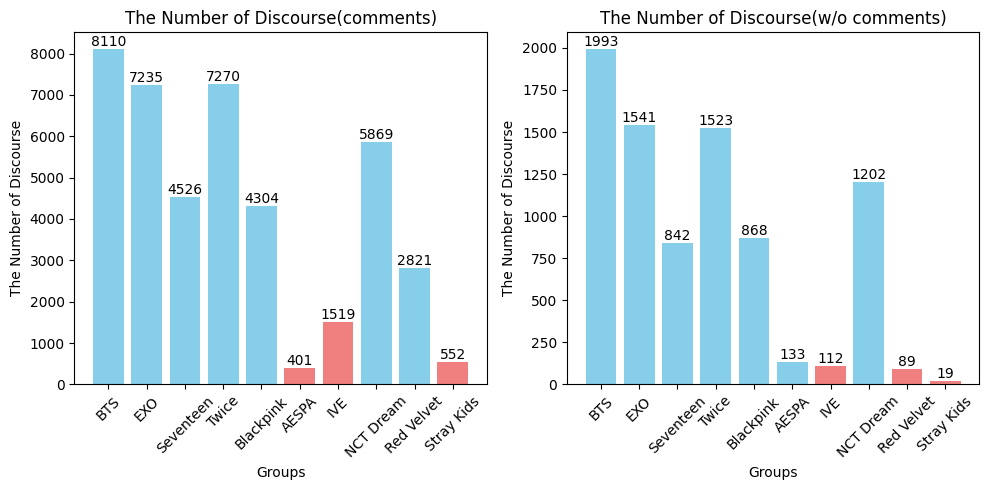

In [ ]:
def plot_bar_chart(data_sizes, title, xlabel, ylabel, rotation=45):
    groups = list(data_sizes.keys())
    values = list(data_sizes.values())

    threshold = np.quantile(values, 0.3)
    colors = ['lightcoral' if value <= threshold else 'skyblue' for value in values]

    bars = plt.bar(groups, values, color=colors)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plot_bar_chart(group_data_sizes_with_comments,
               title='The Number of Discourse(comments)',
               xlabel='Groups', ylabel='The Number of Discourse')

plt.subplot(1, 2, 2)
plot_bar_chart(group_data_sizes_without_comments,
               title='The Number of Discourse(w/o comments)',
               xlabel='Groups', ylabel='The Number of Discourse')

plt.tight_layout()
plt.show()

'BTS' undoubtedly has the highest number of discourse aligning with their popularity and fame, 'EXO' in the 2nd place, 'Twice' also positioned around where they should be located. Meanwhile, 'Nct dream' which is considered as a newer and less popular than 'Seventeen' and 'Blackpink' ranks 4th, which is a compelling result.

The most unnatural observations are 'Aespa' and 'Stray Kids' who have too little discourses compared to other groups. e.g. 'Aespa' has 401 discourse which is only 4.9% of the number of 'BTS' discourses 8110. 'Stray Kids' has 552 discourse which is slightly better than 'Aespa' but still it is only 30% of the newest group 'IVE' discourse 1519.

In both comments matching and no comments matching dataset, the lowest 30% of the number of comments groups are 'Aespa', 'Red Velvet' and 'Stray Kids'.

The fact that some groups have significant less or more discourses than other groups are nurturing the need of good insight from specific topin engagement by topic modeling.

## Frequency of posts

###Frequency of posts by group

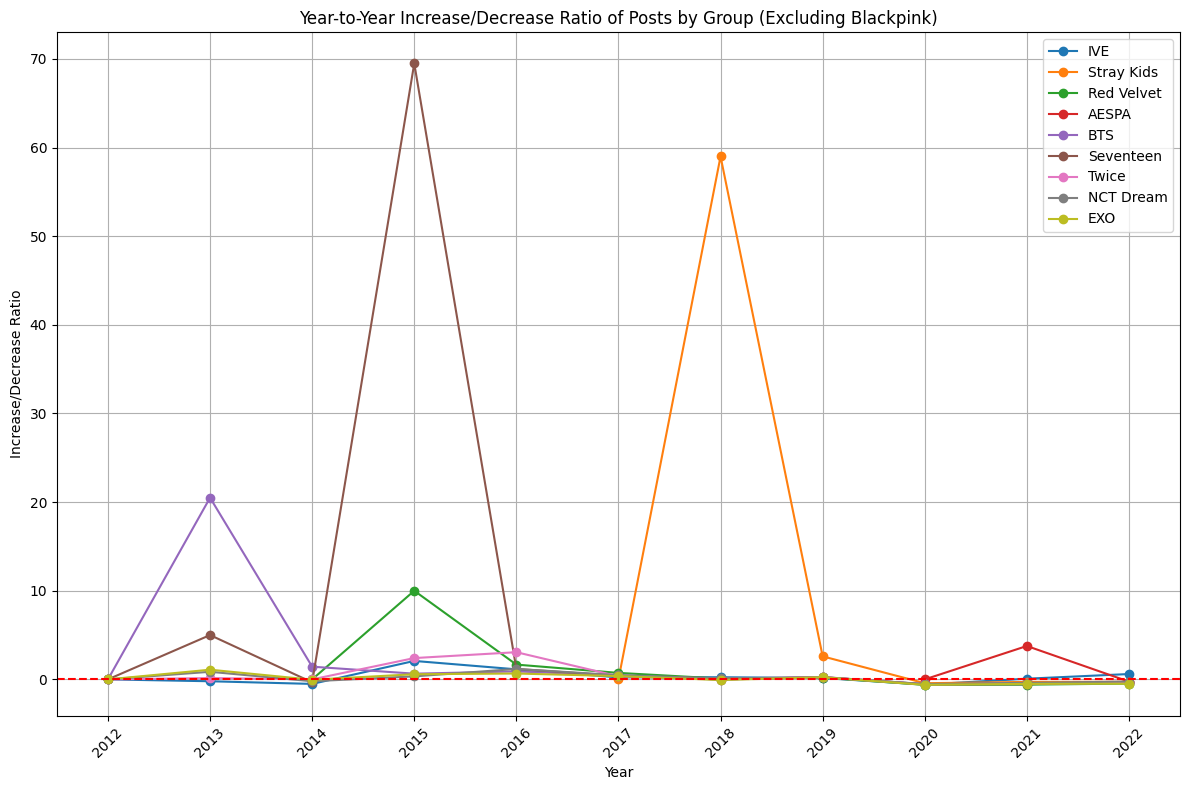

In [ ]:
post_frequencies = {}
increase_decrease_ratios = {}

for group in group_names_dict.keys() - {'Blackpink'}:
    group_filtered_incl_comments[group]['date'] = pd.to_datetime(group_filtered_incl_comments[group]['date'])
    yearly_post_frequency = group_filtered_incl_comments[group].groupby(group_filtered_incl_comments[group]['date'].dt.to_period('Y')).size()
    increase_decrease_ratio = yearly_post_frequency.pct_change().fillna(0)  # NaN을 0으로 대체
    post_frequencies[group] = yearly_post_frequency
    increase_decrease_ratios[group] = increase_decrease_ratio

plt.figure(figsize=(12, 8))

for group in increase_decrease_ratios.keys():
    plt.plot(increase_decrease_ratios[group].index.astype(str), increase_decrease_ratios[group], marker='o', label=group)

plt.title('Year-to-Year Increase/Decrease Ratio of Posts by Group (Excluding Blackpink)')
plt.xlabel('Year')
plt.ylabel('Increase/Decrease Ratio')
plt.axhline(0, color='red', linestyle='--')  # 0선을 추가
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Exclude Blackpink due to the huge difference on their debut year

###Frequency of posts - popular vs less popular

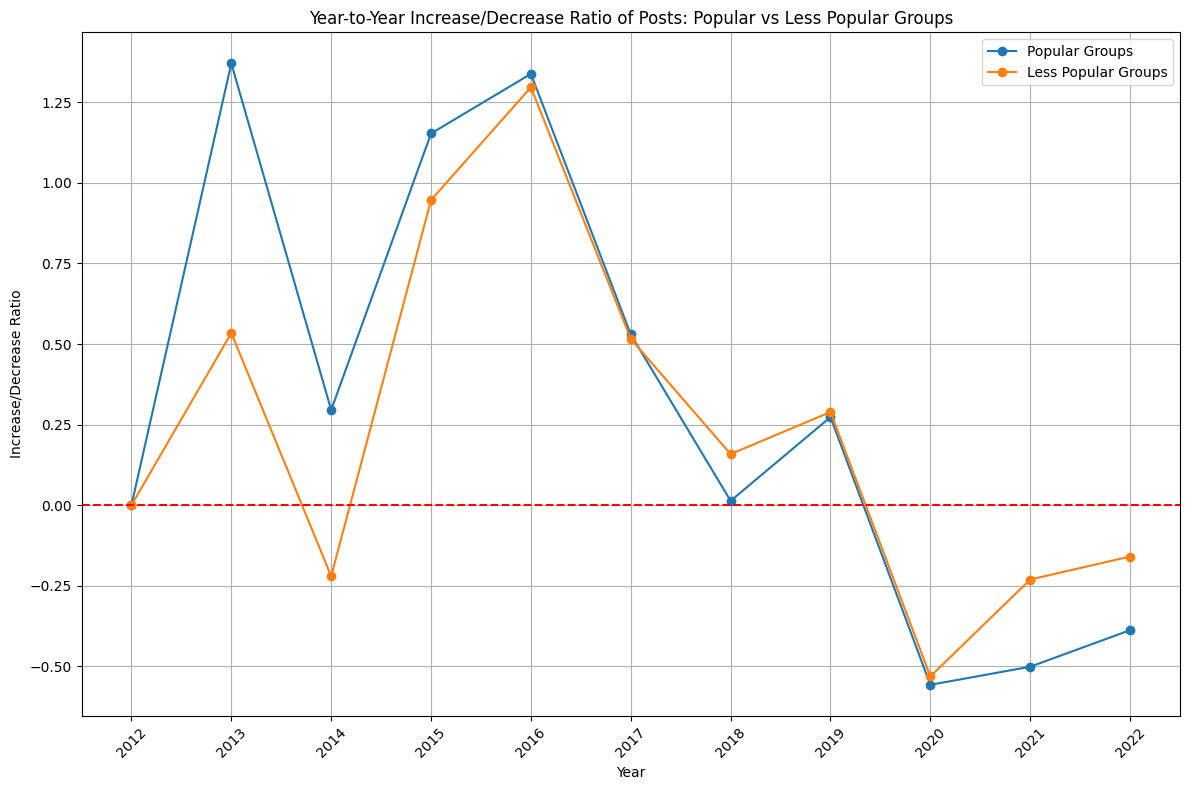

In [ ]:
post_frequencies = {}
increase_decrease_ratios = {}

combined_post_frequencies = {
    'Popular Groups': pd.Series(dtype=int),
    'Less Popular Groups': pd.Series(dtype=int)
}

for group in popular_groups + less_popular_groups:
    group_filtered_incl_comments[group]['date'] = pd.to_datetime(group_filtered_incl_comments[group]['date'])
    yearly_post_frequency = group_filtered_incl_comments[group].groupby(group_filtered_incl_comments[group]['date'].dt.to_period('Y')).size()

    if group in popular_groups:
        combined_post_frequencies['Popular Groups'] = combined_post_frequencies['Popular Groups'].add(yearly_post_frequency, fill_value=0)
    else:
        combined_post_frequencies['Less Popular Groups'] = combined_post_frequencies['Less Popular Groups'].add(yearly_post_frequency, fill_value=0)

increase_decrease_ratios['Popular Groups'] = combined_post_frequencies['Popular Groups'].pct_change().fillna(0)
increase_decrease_ratios['Less Popular Groups'] = combined_post_frequencies['Less Popular Groups'].pct_change().fillna(0)

plt.figure(figsize=(12, 8))

for group in increase_decrease_ratios.keys():
    plt.plot(increase_decrease_ratios[group].index.astype(str), increase_decrease_ratios[group], marker='o', label=group)

plt.title('Year-to-Year Increase/Decrease Ratio of Posts: Popular vs Less Popular Groups')
plt.xlabel('Year')
plt.ylabel('Increase/Decrease Ratio')
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Post length per group

### Max post length per group

In [ ]:
body_info_per_group = {}
average_lengths_per_group = {}

# excluding comments
for group, df in group_filtered_excl_comments.items():
    df = df.copy()
    df['word_count'] = df['body'].apply(lambda x: len(str(x).split()))

    max_body_length = df['word_count'].max()
    average_length = df['word_count'].mean() if len(df) > 0 else 0

    max_body_info = df.loc[df['word_count'].idxmax(), ['title', 'body', 'comments']].to_dict()

    body_info_per_group[group] = (max_body_length, max_body_info)
    average_lengths_per_group[group] = average_length

group_with_longest_body = max(body_info_per_group, key=lambda x: body_info_per_group[x][0])

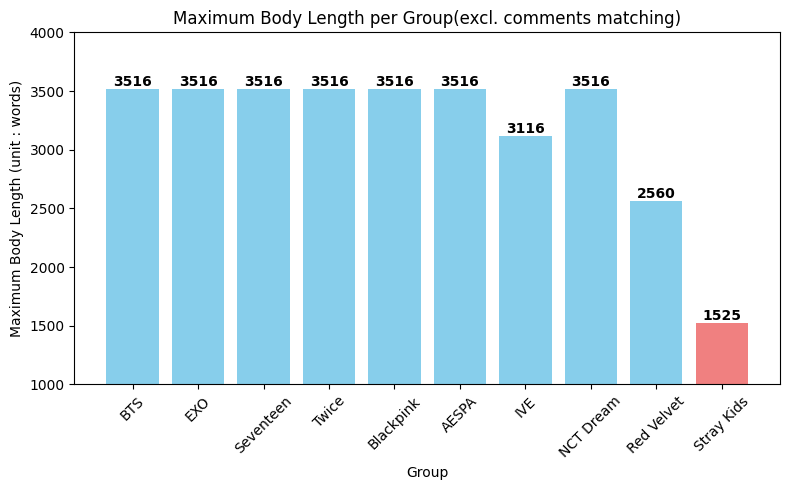

In [ ]:
def plot_max_body_length(body_info_per_group):
    groups = [group for group in body_info_per_group]
    lengths = [info[0] for info in body_info_per_group.values()]

    min_length_index = lengths.index(min(lengths))
    colors = ['skyblue' for _ in groups]
    colors[min_length_index] = 'lightcoral'

    plt.figure(figsize=(8, 5))
    bars = plt.bar(groups, lengths, color=colors)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, str(yval), va='bottom', ha='center', fontweight='bold')

    plt.xlabel('Group')
    plt.ylabel('Maximum Body Length (unit : words)')
    plt.title('Maximum Body Length per Group(excl. comments matching)')
    plt.xticks(rotation=45)
    plt.ylim(1000, 4000)
    plt.tight_layout()
    plt.show()

plot_max_body_length(body_info_per_group)

### Average post length per group

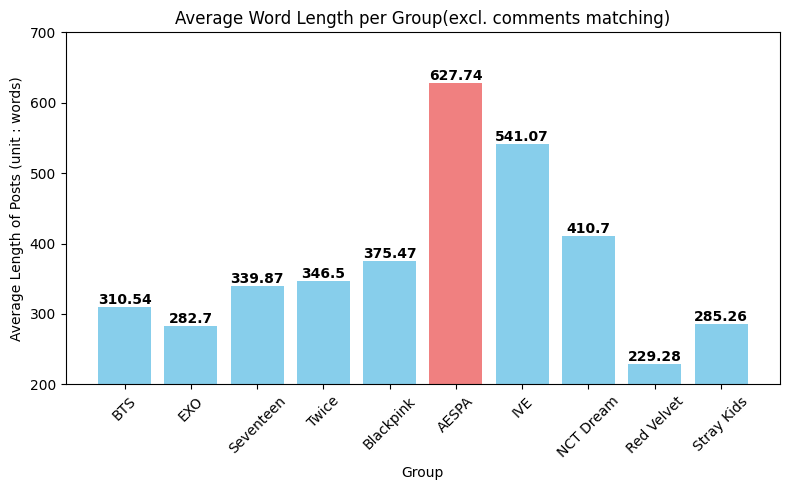

In [ ]:
def plot_average_lengths(average_lengths_per_group):
    groups = list(average_lengths_per_group.keys())
    avg_lengths = list(average_lengths_per_group.values())

    max_avg_length_index = avg_lengths.index(max(avg_lengths))

    colors = ['skyblue' for _ in groups]
    colors[max_avg_length_index] = 'lightcoral'

    plt.figure(figsize=(8, 5))
    bars = plt.bar(groups, avg_lengths, color=colors)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2),
                 va='bottom', ha='center', fontweight='bold')

    plt.xlabel('Group')
    plt.ylabel('Average Length of Posts (unit : words)')
    plt.title('Average Word Length per Group(excl. comments matching)')
    plt.xticks(rotation=45)
    plt.ylim(200, 700)
    plt.tight_layout()
    plt.show()

plot_average_lengths(average_lengths_per_group)

AESPA has the highest average post length
* But # of posts are smaller --> shows high fan engagement

###Average post length - popular vs less popular

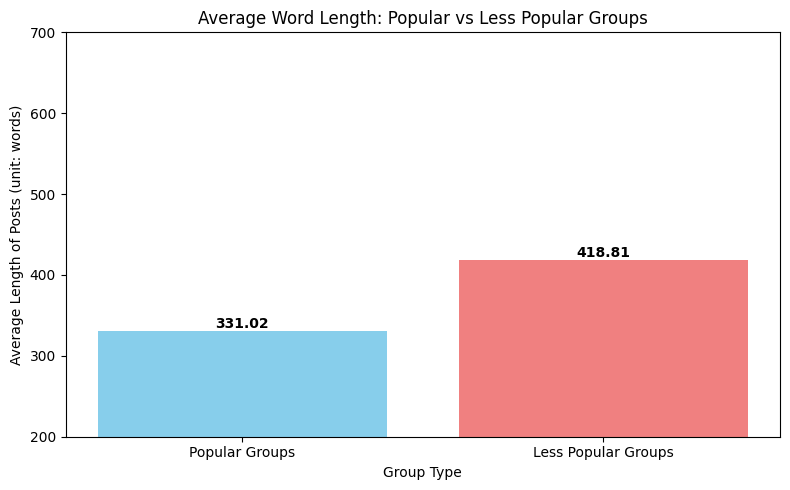

In [ ]:
popular_avg_length = 0
less_popular_avg_length = 0

for group in popular_groups:
    if group in average_lengths_per_group:
        popular_avg_length += average_lengths_per_group[group]

popular_avg_length /= len(popular_groups)

for group in less_popular_groups:
    if group in average_lengths_per_group:
        less_popular_avg_length += average_lengths_per_group[group]

less_popular_avg_length /= len(less_popular_groups)

categories = ['Popular Groups', 'Less Popular Groups']
average_lengths = [popular_avg_length, less_popular_avg_length]

plt.figure(figsize=(8, 5))
bars = plt.bar(categories, average_lengths, color=['skyblue', 'lightcoral'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2),
             va='bottom', ha='center', fontweight='bold')

plt.xlabel('Group Type')
plt.ylabel('Average Length of Posts (unit: words)')
plt.title('Average Word Length: Popular vs Less Popular Groups')
plt.ylim(200, 700)
plt.tight_layout()
plt.show()

##Score

###Average score by group

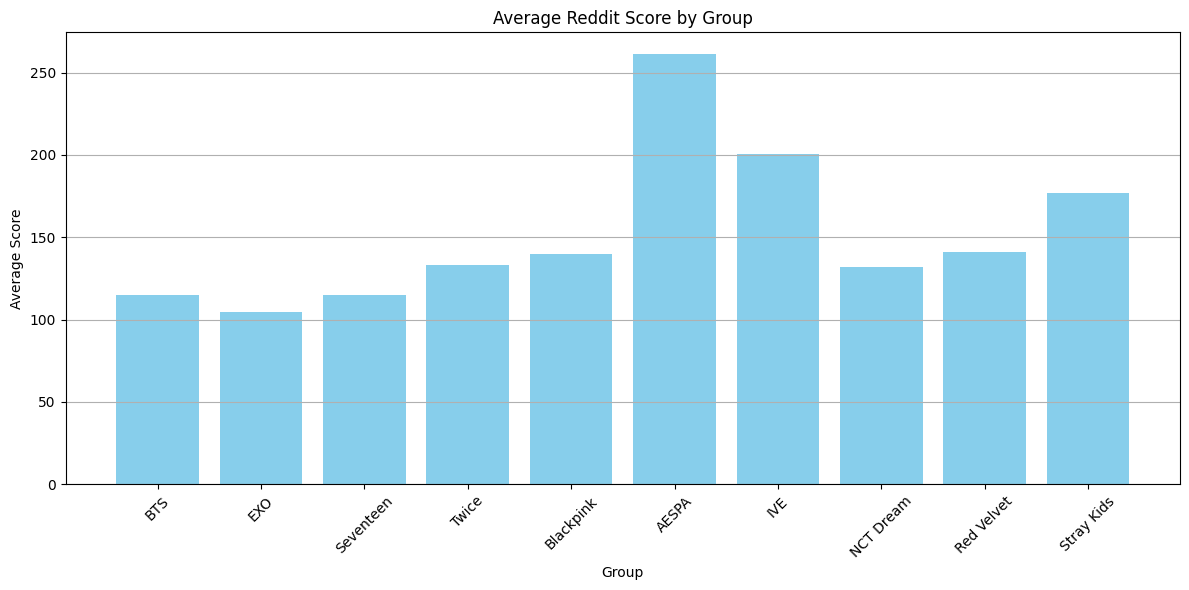

In [ ]:
average_scores = {}

for group in group_names_dict.keys():
    average_scores[group] = group_filtered_incl_comments[group]['score'].mean()

average_scores_df = pd.DataFrame(list(average_scores.items()), columns=['Group', 'Average Score'])

plt.figure(figsize=(12, 6))
plt.bar(average_scores_df['Group'], average_scores_df['Average Score'], color='skyblue')
plt.title('Average Reddit Score by Group')
plt.xlabel('Group')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

###Average score - popular vs less popular

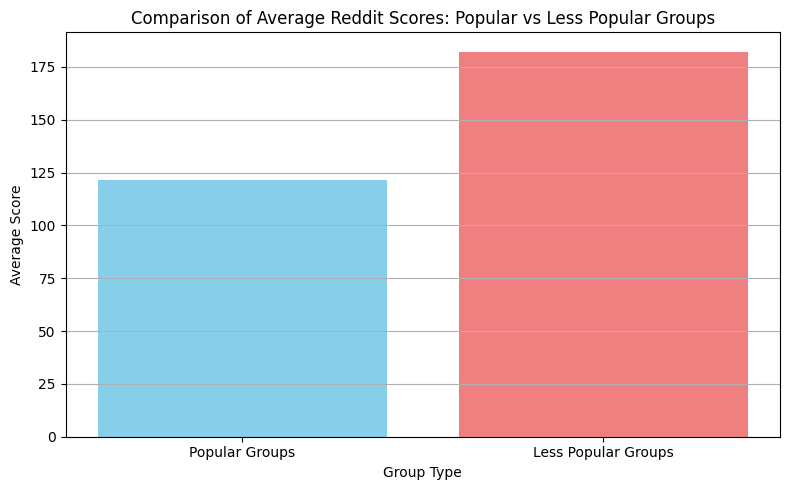

In [ ]:
popular_average_score = average_scores_df[average_scores_df['Group'].isin(popular_groups)]['Average Score'].mean()
less_popular_average_score = average_scores_df[average_scores_df['Group'].isin(less_popular_groups)]['Average Score'].mean()

comparison_df = pd.DataFrame({
    'Group Type': ['Popular Groups', 'Less Popular Groups'],
    'Average Score': [popular_average_score, less_popular_average_score]
})

plt.figure(figsize=(8, 5))
plt.bar(comparison_df['Group Type'], comparison_df['Average Score'], color=['skyblue', 'lightcoral'])
plt.title('Comparison of Average Reddit Scores: Popular vs Less Popular Groups')
plt.xlabel('Group Type')
plt.ylabel('Average Score')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## The number of comments per group


### Max number of comments
Popular post?

In [ ]:
def find_max_comments_post_per_group(groups_data):
    max_comments_post_per_group = {}
    for group_name, dataframe in groups_data.items():
        max_comments = dataframe['num_comments'].max()
        max_comments_post = dataframe[dataframe['num_comments'] == max_comments]
        max_comments_post_per_group[group_name] = (max_comments, max_comments_post.iloc[0]['title'])

    max_comments_post_df = pd.DataFrame.from_dict(max_comments_post_per_group, orient='index').reset_index()
    max_comments_post_df.columns = ['Group name', 'The highest number of comments', 'Title']
    return max_comments_post_df
max_comments_incl_comments = find_max_comments_post_per_group(group_filtered_incl_comments)
max_comments_excl_comments = find_max_comments_post_per_group(group_filtered_excl_comments)

max_comments_incl_comments

,Group name,The highest number of comments,Title
0,BTS,11887,mnet asian music awards 2020 mama 2020 discuss...
1,EXO,11887,mnet asian music awards 2020 mama 2020 discuss...
2,Seventeen,11887,mnet asian music awards 2020 mama 2020 discuss...
3,Twice,11887,mnet asian music awards 2020 mama 2020 discuss...
4,Blackpink,11887,mnet asian music awards 2020 mama 2020 discuss...
5,AESPA,11887,mnet asian music awards 2020 mama 2020 discuss...
6,IVE,11887,mnet asian music awards 2020 mama 2020 discuss...
7,NCT Dream,11887,mnet asian music awards 2020 mama 2020 discuss...
8,Red Velvet,11887,mnet asian music awards 2020 mama 2020 discuss...
9,Stray Kids,11887,mnet asian music awards 2020 mama 2020 discuss...


In [ ]:
max_comments_excl_comments

,Group name,The highest number of comments,Title
0,BTS,11887,mnet asian music awards 2020 mama 2020 discuss...
1,EXO,5108,smtown live 2022 smcu express @kwangya kangta ...
2,Seventeen,11887,mnet asian music awards 2020 mama 2020 discuss...
3,Twice,11887,mnet asian music awards 2020 mama 2020 discuss...
4,Blackpink,11887,mnet asian music awards 2020 mama 2020 discuss...
5,AESPA,11887,mnet asian music awards 2020 mama 2020 discuss...
6,IVE,11337,mnet asian music awards 2022 mama 2022 discuss...
7,NCT Dream,11887,mnet asian music awards 2020 mama 2020 discuss...
8,Red Velvet,529,new years giveaway time 1 twice amp rv
9,Stray Kids,162,2019 hanteo annual chart


Every group show the same post(with comments) that has the most number of comments(11,887 comments) about the biggest 'Music Award', which is so-called 'MAMA' topic that can't help but to have every group emergence

### Average number of comments per group
Averagely attractive post?
* Median used
* AESPA # of posts : 401 <<< BTS # of posts : 8110
* AESPA # of max comments : 11887 === BTS # of max comments : 11887
* They share the same posts that can be highly impact on average

In [ ]:
def calculate_average_comments_per_group(groups_data):
    average_num_comments_per_group = {}
    for group_name, dataframe in groups_data.items():
        avg_comments = dataframe['num_comments'].median()
        average_num_comments_per_group[group_name] = avg_comments
    return average_num_comments_per_group
average_comments_incl_comments = calculate_average_comments_per_group(group_filtered_incl_comments)
average_comments_excl_comments = calculate_average_comments_per_group(group_filtered_excl_comments)

average_comments_incl_comments_df = pd.DataFrame(list(average_comments_incl_comments.items()), columns=['Group name', 'Average number of comments'])
average_comments_excl_comments_df = pd.DataFrame(list(average_comments_excl_comments.items()), columns=['Group name', 'Average number of comments'])

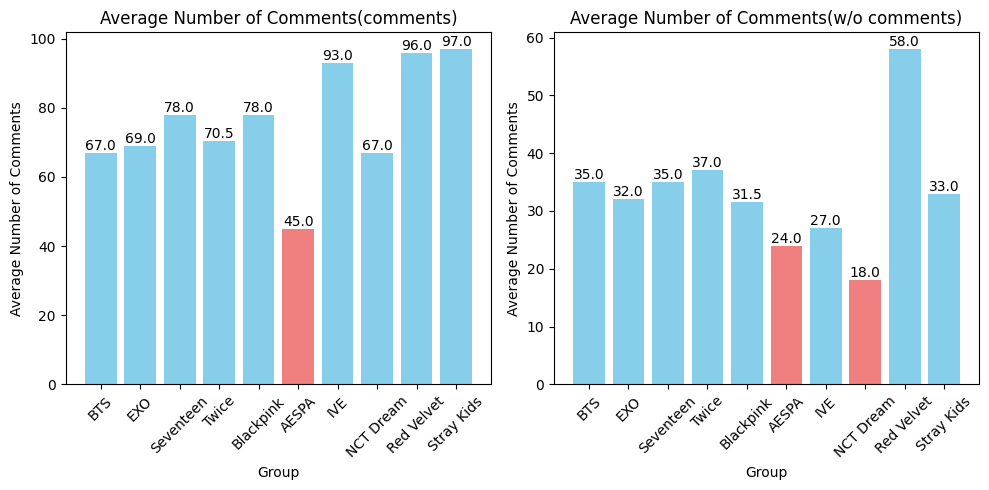

In [ ]:
def plot_average_comments(df, ax, title):
    groups = list(df['Group name'])
    average_comments = list(df['Average number of comments'])

    threshold = np.percentile(average_comments, 20)
    colors = ['lightcoral' if x < threshold else 'skyblue' for x in average_comments]
    bars = ax.bar(groups, average_comments, color=colors)

    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

    ax.set_xlabel('Group')
    ax.set_ylabel('Average Number of Comments')
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=45)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plot_average_comments(average_comments_incl_comments_df, axs[0], 'Average Number of Comments(comments)')
plot_average_comments(average_comments_excl_comments_df, axs[1], 'Average Number of Comments(w/o comments)')

plt.tight_layout()
plt.show()

'AESPA' shows the lowest median number of comments per post

###Average number of comments - popular vs less popular

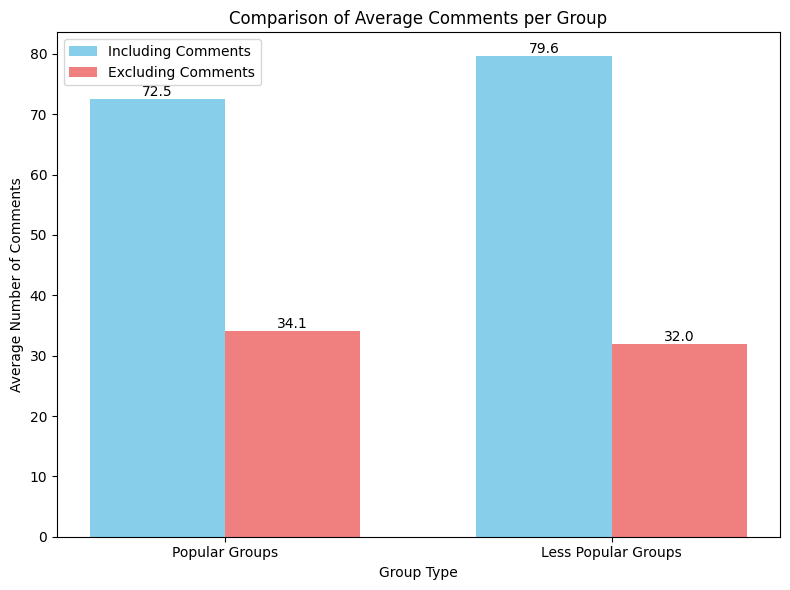

In [ ]:
popular_avg_incl = average_comments_incl_comments_df[average_comments_incl_comments_df['Group name'].isin(popular_groups)]['Average number of comments'].mean()
popular_avg_excl = average_comments_excl_comments_df[average_comments_excl_comments_df['Group name'].isin(popular_groups)]['Average number of comments'].mean()

less_popular_avg_incl = average_comments_incl_comments_df[average_comments_incl_comments_df['Group name'].isin(less_popular_groups)]['Average number of comments'].mean()
less_popular_avg_excl = average_comments_excl_comments_df[average_comments_excl_comments_df['Group name'].isin(less_popular_groups)]['Average number of comments'].mean()

comparison_data = pd.DataFrame({
    'Group Type': ['Popular Groups', 'Less Popular Groups'],
    'Average Comments (incl)': [popular_avg_incl, less_popular_avg_incl],
    'Average Comments (excl)': [popular_avg_excl, less_popular_avg_excl]
})

fig, ax = plt.subplots(figsize=(8, 6))

width = 0.35
x = np.arange(len(comparison_data['Group Type']))

bars1 = ax.bar(x - width/2, comparison_data['Average Comments (incl)'], width, label='Including Comments', color='skyblue')
bars2 = ax.bar(x + width/2, comparison_data['Average Comments (excl)'], width, label='Excluding Comments', color='lightcoral')

for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

ax.set_xlabel('Group Type')
ax.set_ylabel('Average Number of Comments')
ax.set_title('Comparison of Average Comments per Group')
ax.set_xticks(x)
ax.set_xticklabels(comparison_data['Group Type'])
ax.legend()

plt.tight_layout()
plt.show()

## Word frequency
What are the most frequent words?

### Most frequent words across all fan discourse

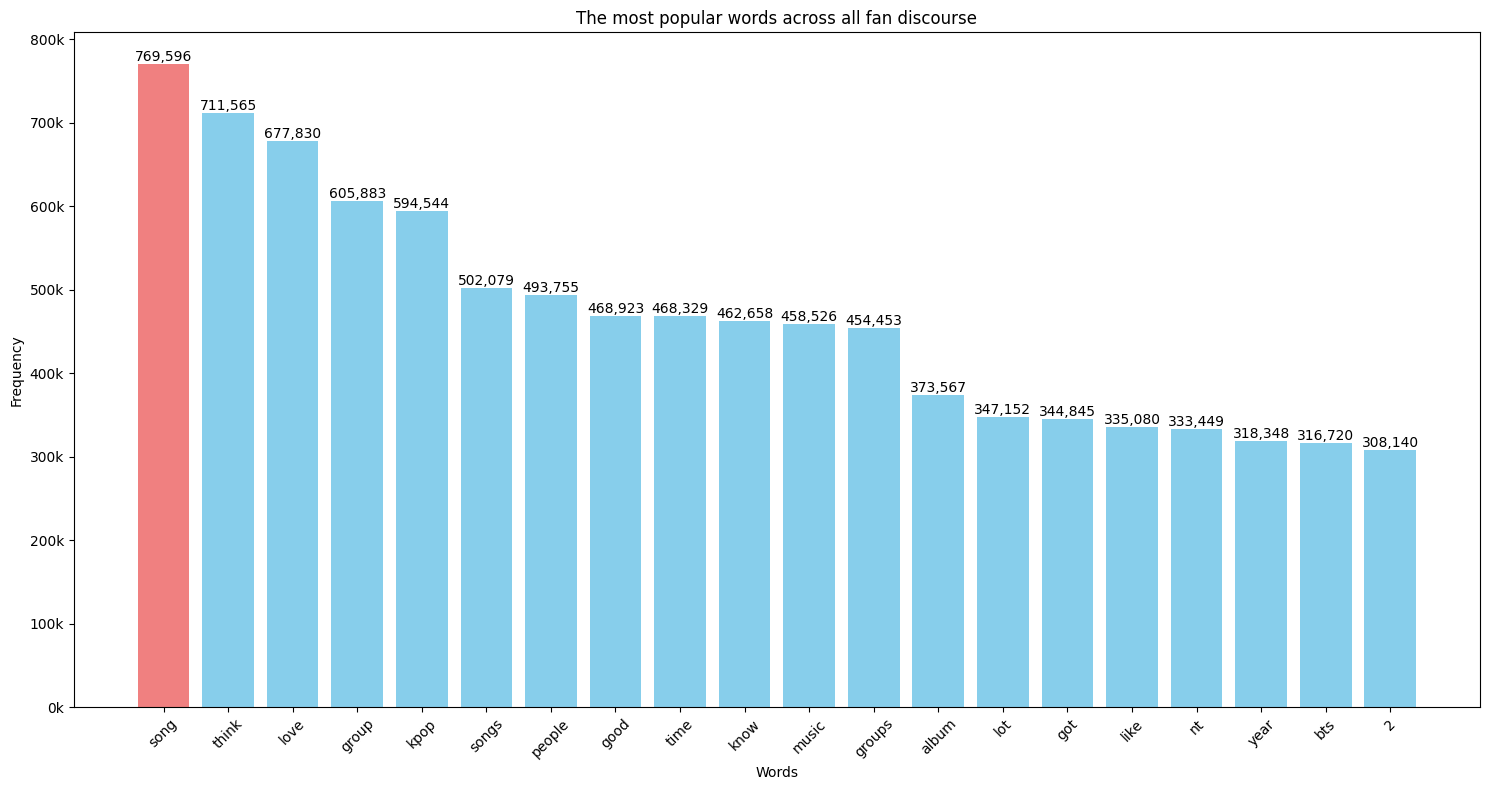

In [ ]:
from matplotlib.ticker import FuncFormatter

def count_words(dataframe):
    counter = Counter()
    for index, row in dataframe.iterrows():
        texts = f"{row['title']} {row['body']} {' '.join(row['comments']) if isinstance(row['comments'], list) else ''}"
        words = texts.split()
        counter.update(words)
    return counter

total_word_count = Counter()
for df in group_filtered_incl_comments.values():
    total_word_count.update(count_words(df))

top_words = total_word_count.most_common(20)
words, frequencies = zip(*top_words)

colors = ['lightcoral' if i == 0 else 'skyblue' for i in range(len(words))]

def thousands_formatter(x, pos):
    return f'{int(x/1000)}k'

plt.figure(figsize=(15, 8))
bars = plt.bar(words, frequencies, color=colors)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{int(yval):,}', ha='center', va='bottom')

formatter = FuncFormatter(thousands_formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.title('The most popular words across all fan discourse')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

'song', 'think', 'love', 'group', 'kpop', 'songs', 'people', 'good'... are shown up in any group with a slight difference on ranking.
It reflects the fact that fan engagement highly based on showing their affection (love).

###Most frequent words per group

In [ ]:
documents_per_group = {}
for group, df in group_filtered_incl_comments.items():
    group_documents = df.apply(lambda x: f"{x['title']} {x['body']} {' '.join(x['comments']) if isinstance(x['comments'], list) else x['comments']}", axis=1)
    documents_per_group[group] = " ".join(group_documents)

count_vectorizer = CountVectorizer(stop_words='english')

top_words_per_group = {}
for group, document in documents_per_group.items():
    count_matrix = count_vectorizer.fit_transform([document])
    feature_names = count_vectorizer.get_feature_names_out()
    sorted_items = sorted(zip(count_matrix.toarray()[0], feature_names), reverse=True, key=lambda x: x[0])

    top_words_frequencies = [(item[1], item[0]) for item in sorted_items[:10]]
    top_words_per_group[group] = top_words_frequencies

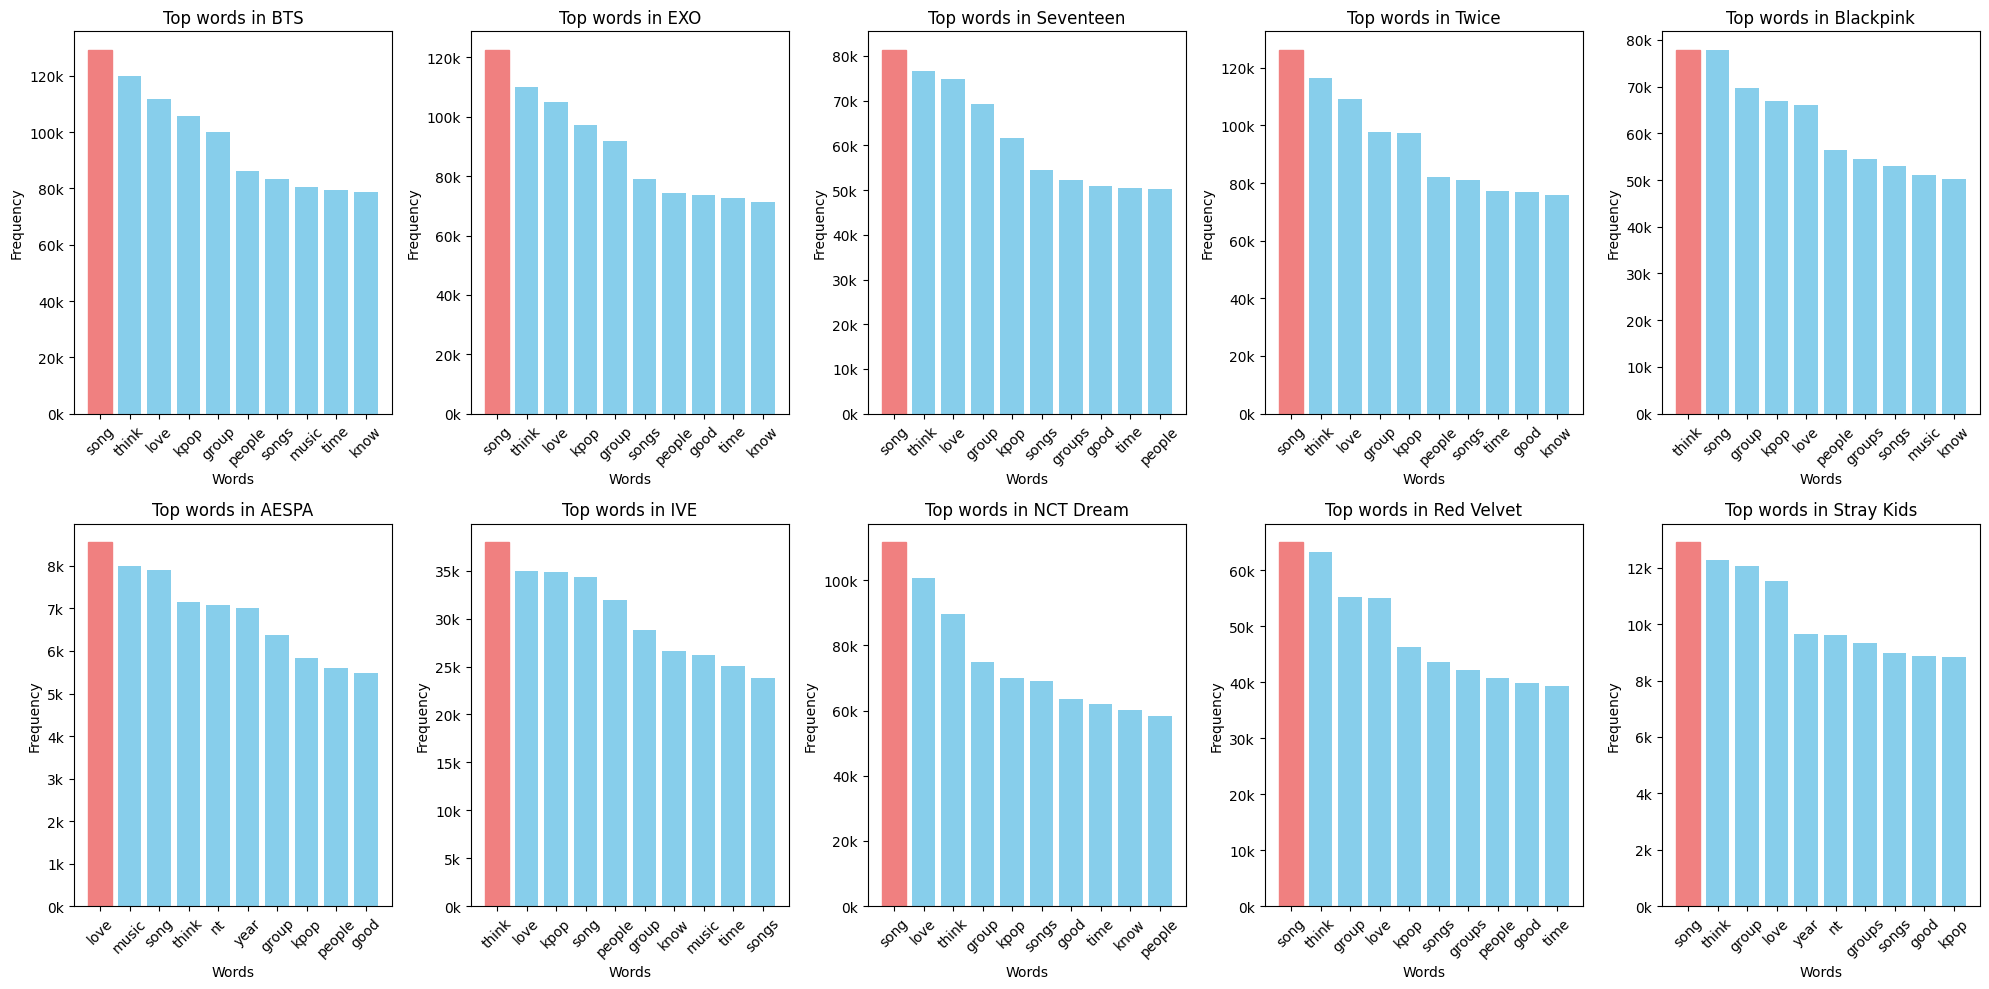

In [ ]:
colors = ['skyblue', 'lightcoral']
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

axs = axs.flatten()

for i, (group, top_words) in enumerate(top_words_per_group.items()):
    words = [word_freq[0] for word_freq in top_words]
    frequencies = [word_freq[1] for word_freq in top_words]

    bars = axs[i].bar(words, frequencies, color=colors[0])
    bars[0].set_color(colors[1])

    axs[i].yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    axs[i].set_title(f'Top words in {group}')
    axs[i].set_xlabel('Words')
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].set_ylabel('Frequency')

for i in range(len(group_filtered_incl_comments), len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

Very little difference among groups

###Most frequent but unique words per group

In [ ]:
documents_per_group = {}
for group, df in group_filtered_incl_comments.items():
    group_documents = df.apply(lambda x: f"{x['title']} {x['body']} {' '.join(x['comments']) if isinstance(x['comments'], list) else x['comments']}", axis=1)
    documents_per_group[group] = list(group_documents)

all_documents = [doc for docs in documents_per_group.values() for doc in docs]

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5, min_df=0.05)
tfidf_matrix = tfidf_vectorizer.fit_transform(all_documents)
feature_names = tfidf_vectorizer.get_feature_names_out()

unique_word_per_group = {}
for group, docs in documents_per_group.items():
    tfidf_matrix = tfidf_vectorizer.fit_transform(docs)
    feature_names = tfidf_vectorizer.get_feature_names_out()
    mean_tfidf_scores = tfidf_matrix.mean(axis=0)

    top_words = []
    for _ in range(3):
        max_index = mean_tfidf_scores.argmax()
        unique_word = feature_names[max_index]
        unique_score = mean_tfidf_scores[0, max_index]
        top_words.append((unique_word, unique_score))
        mean_tfidf_scores[0, max_index] = 0

    unique_word_per_group[group] = top_words

In [ ]:
for group, top_words in unique_word_per_group.items():
    formatted_words = ', '.join([f"{word} ({score:.4f})" for word, score in top_words])
    print(f"Most unique words in {group}: {formatted_words}")

Most unique words in BTS: idols (0.0272), comments (0.0249), listening (0.0242)
Most unique words in EXO: idols (0.0264), listening (0.0251), stage (0.0251)
Most unique words in Seventeen: albums (0.0261), voice (0.0234), concept (0.0222)
Most unique words in Twice: comments (0.0254), sm (0.0247), albums (0.0239)
Most unique words in Blackpink: comments (0.0271), yg (0.0241), concept (0.0229)
Most unique words in AESPA: apple (0.0754), comments (0.0681), feat (0.0281)
Most unique words in IVE: comments (0.0226), friends (0.0218), concert (0.0205)
Most unique words in NCT Dream: sm (0.0267), snsd (0.0245), idols (0.0245)
Most unique words in Red Velvet: chorus (0.0243), yg (0.0222), loona (0.0222)
Most unique words in Stray Kids: sales (0.0249), chan (0.0246), bias (0.0244)


###Most frequent but unique words - popular vs less popular

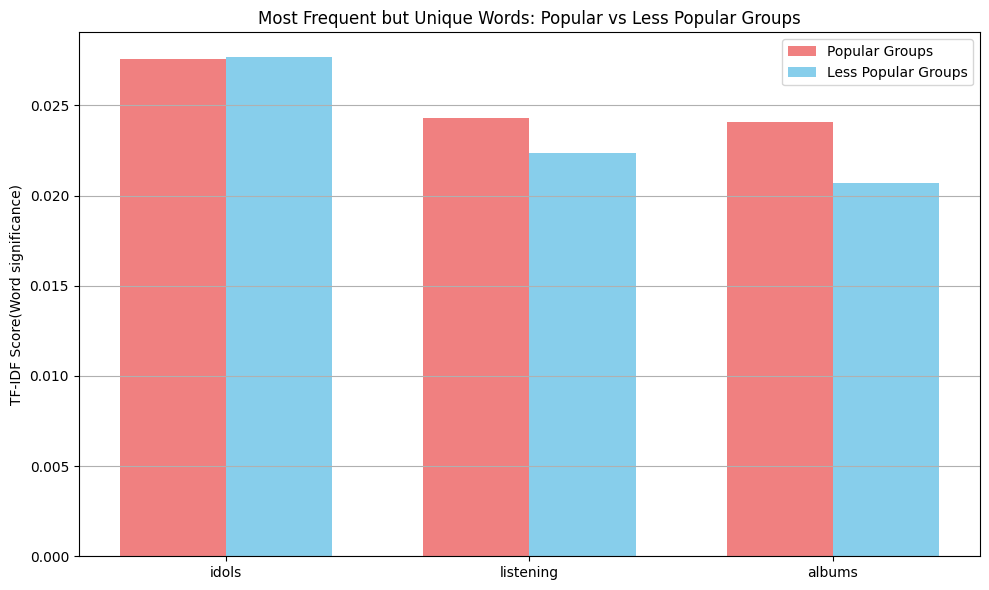

In [ ]:
popular_documents = []
for group in popular_groups:
    popular_documents.extend(documents_per_group[group])

less_popular_documents = []
for group in less_popular_groups:
    less_popular_documents.extend(documents_per_group[group])

def get_top_unique_words(documents, top_n=3):
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5, min_df=0.05)
    tfidf_matrix = tfidf_vectorizer.fit_transform(documents)
    feature_names = tfidf_vectorizer.get_feature_names_out()
    mean_tfidf_scores = tfidf_matrix.mean(axis=0)

    top_words = []
    for _ in range(top_n):
        max_index = mean_tfidf_scores.argmax()
        unique_word = feature_names[max_index]
        unique_score = mean_tfidf_scores[0, max_index]
        top_words.append((unique_word, unique_score))
        mean_tfidf_scores[0, max_index] = 0

    return top_words

popular_top_words = get_top_unique_words(popular_documents)
less_popular_top_words = get_top_unique_words(less_popular_documents)

popular_words, popular_scores = zip(*popular_top_words)
less_popular_words, less_popular_scores = zip(*less_popular_top_words)

top_words_df = pd.DataFrame({
    'Popular Groups': popular_words,
    'Popular Scores': popular_scores,
    'Less Popular Groups': less_popular_words,
    'Less Popular Scores': less_popular_scores
})

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
x = range(len(popular_top_words))

ax.bar(x, popular_scores, width=bar_width, label='Popular Groups', color='lightcoral')
ax.bar([p + bar_width for p in x], less_popular_scores, width=bar_width, label='Less Popular Groups', color='skyblue')

ax.set_title('Most Frequent but Unique Words: Popular vs Less Popular Groups')
ax.set_ylabel('TF-IDF Score(Word significance)')
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(popular_words)
ax.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#Topic list setup

In [ ]:
def transform_to_tfidf(documents, max_features=1000):
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
    tfidf_matrix = tfidf_vectorizer.fit_transform(documents)
    return tfidf_matrix, tfidf_vectorizer
def perform_kmeans(tfidf_matrix, num_clusters, n_init=10, random_state=42):
    kmeans = KMeans(n_clusters=num_clusters, n_init=n_init, random_state=random_state)
    kmeans.fit(tfidf_matrix)
    return kmeans

In [ ]:
all_documents = [doc for docs in documents_per_group.values() for doc in docs]
tfidf_matrix, tfidf_vectorizer = transform_to_tfidf(all_documents)

In [ ]:
n_cluster = 15
kmeans = perform_kmeans(tfidf_matrix, n_cluster)

order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()

for i in range(n_cluster):
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"Cluster {i+1}: {', '.join(top_terms)}")

Cluster 1: song, love, kpop, songs, think, group, music, good, amp, know
Cluster 2: song, songs, love, chorus, think, good, like, listen, time, lyrics
Cluster 3: think, love, lol, group, members, time, know, video, got, idol
Cluster 4: album, song, love, songs, albums, good, listening, track, listen, favorite
Cluster 5: kpop, concert, time, think, know, got, love, people, good, going
Cluster 6: kpop, music, groups, people, think, songs, song, got, time, group
Cluster 7: people, think, fans, idols, kpop, group, know, groups, time, lot
Cluster 8: comments, apple, music, youtube, thread, feat, votes, week, kpop, live
Cluster 9: group, groups, think, members, music, debut, year, sm, kpop, songs
Cluster 10: dance, choreo, choreography, love, dancer, dancing, dancers, practice, song, think
Cluster 11: love, song, songs, red, velvet, nct, amp, 10, bts, kpop
Cluster 12: stage, performance, song, performances, award, live, love, good, think, year
Cluster 13: cover, song, group, love, link, cove

In [ ]:
topic_list = {
    1: "Awards and Achievements",
    2: "Groups and Members",
    3: "Live Performances",
    4: "Dance and Choreography",
    5: "Culture and Community",
    6: "Music Charts and Trends",
    7: "Album Sales and Statistics",
    8: "Entertainment Companies, Debuts and Comeback",
    9: "Song Lyrics and Themes",
    10: "Albums and Tracks",
    11: "K-pop Songs",
    12: "Fans and Idols",
    13: "General K-pop Discussions",
    14: "Listening Experiences",
    15: "Vocals and Rap Skills"
}

#Topic Modeling

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [ ]:
import hdbscan
embedding_model = SentenceTransformer("paraphrase-MiniLM-L6-v2",device=device)
umap = UMAP(n_neighbors=30, n_components=2, min_dist=0.0, metric='cosine', random_state=42)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def BERTopic_group(documents):
    hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
    topic_model = BERTopic(embedding_model=embedding_model, umap_model=umap, hdbscan_model=hdbscan_model, verbose=False)
    topics = topic_model.fit_transform(documents)
    return topic_model

In [ ]:
def topic_modeling_visualization(topic_model) :
    print(f"Number of topics : {len(topic_model.get_topic_info())}")
    return topic_model.get_topic_info()[['Topic','Count','Name','Representation']]

In [ ]:
def topic_mapping(group_topics):
    topic_mapping = []
    for doc in group_topics:
        if 'group' in doc or 'member' in doc:
            topic_mapping.append(1)  # Awards and Achievements
        elif 'album' in doc or 'track' in doc or 'song' in doc:
            topic_mapping.append(10)  # Albums and Tracks
        elif 'dance' in doc or 'choreo' in doc or 'vocal' in doc or 'rap' in doc:
            topic_mapping.append(4)  # Dance and Choreography / Vocals and Rap Skills
        elif 'fan' in doc or 'engagement' in doc:
            topic_mapping.append(12)  # Fans and Idols
        elif 'music' in doc or 'attribute' in doc:
            topic_mapping.append(6)  # Music Charts and Trends
        elif 'trend' in doc or 'kpop' in doc:
            topic_mapping.append(5)  # Culture and Community
        elif 'online' in doc or 'activity' in doc:
            topic_mapping.append(8)  # Online activity
        elif 'rank' in doc or 'charts' in doc:
            topic_mapping.append(7)  # Album Sales and Statistics
        elif 'performance' in doc or 'stage' in doc:
            topic_mapping.append(3)  # Live Performances
        elif 'lyrics' in doc or 'theme' in doc:
            topic_mapping.append(9)  # Song Lyrics and Themes
        else:
            topic_mapping.append(None)  # No specific keywords
    return topic_mapping

In [ ]:
def topic_name(topic_info) :
    topic_numbers = set(topic_mapping(topic_info['Representation']))
    topic_names = [topic_list[topic] for topic in topic_numbers if topic is not None]
    topic_info['Topic Name'] = pd.Series(topic_names)
    return topic_info[['Count','Topic Name']].dropna()

## Topic Modeling Group Tables

Stray Kids

In [ ]:
skz_topic_model = BERTopic_group(documents_per_group["Stray Kids"])
skz_topics_info = topic_modeling_visualization(skz_topic_model)
skz_topic = topic_name(skz_topics_info)
skz_topic

Number of topics : 23


,Count,Topic Name
0,131,Awards and Achievements
1,121,Live Performances
2,36,Dance and Choreography
3,27,Culture and Community
4,20,Albums and Tracks


Red Velvet

In [ ]:
rv_topic_model = BERTopic_group(documents_per_group["Red Velvet"])
rv_topics_info = topic_modeling_visualization(rv_topic_model)
rv_topics = topic_name(rv_topics_info)
rv_topics

Number of topics : 119


,Count,Topic Name
0,916,Awards and Achievements
1,77,Live Performances
2,75,Dance and Choreography
3,66,Culture and Community
4,60,Music Charts and Trends
5,58,Albums and Tracks
6,50,Fans and Idols


NCT Dream

In [ ]:
nct_topic_model = BERTopic_group(documents_per_group["NCT Dream"])
nct_topics_info = topic_modeling_visualization(nct_topic_model)
nct_topics = topic_name(nct_topics_info)
nct_topics

Number of topics : 180


,Count,Topic Name
0,1731,Awards and Achievements
1,224,Live Performances
2,223,Dance and Choreography
3,174,Culture and Community
4,101,Music Charts and Trends
5,97,Album Sales and Statistics
6,81,Song Lyrics and Themes
7,80,Albums and Tracks


IVE

In [ ]:
ive_topic_model = BERTopic_group(documents_per_group["IVE"])
ive_topics_info = topic_modeling_visualization(ive_topic_model)
ive_topics = topic_name(ive_topics_info)
ive_topics

Number of topics : 54


,Count,Topic Name
0,388,Awards and Achievements
1,129,Live Performances
2,117,Dance and Choreography
3,94,Culture and Community
4,68,Music Charts and Trends
5,54,Albums and Tracks


AESPA

In [ ]:
aespa_topic_model = BERTopic_group(documents_per_group["AESPA"])
aespa_topics_info = topic_modeling_visualization(aespa_topic_model)
aespa_topics = topic_name(aespa_topics_info)
aespa_topics

Number of topics : 15


,Count,Topic Name
0,69,Awards and Achievements
1,60,Albums and Tracks
2,59,Music Charts and Trends


Black Pink

In [ ]:
bp_topic_model = BERTopic_group(documents_per_group["Blackpink"])
bp_topics_info = topic_modeling_visualization(bp_topic_model)
bp_topics = topic_name(bp_topics_info)
bp_topics

Number of topics : 140


,Count,Topic Name
0,1286,Awards and Achievements
1,218,Live Performances
2,182,Dance and Choreography
3,142,Culture and Community
4,141,Music Charts and Trends
5,126,Album Sales and Statistics
6,85,Song Lyrics and Themes
7,66,Albums and Tracks
8,49,Fans and Idols


Twice

In [ ]:
twice_topic_model = BERTopic_group(documents_per_group["Twice"])
twice_topics_info = topic_modeling_visualization(twice_topic_model)
twice_topics = topic_name(twice_topics_info)
twice_topics

Number of topics : 224


,Count,Topic Name
0,2361,Awards and Achievements
1,328,Live Performances
2,253,Dance and Choreography
3,197,Culture and Community
4,193,Music Charts and Trends
5,158,Album Sales and Statistics
6,152,Song Lyrics and Themes
7,104,Albums and Tracks


Seventeen

In [ ]:
svt_topic_model = BERTopic_group(documents_per_group["Seventeen"])
svt_topics_info = topic_modeling_visualization(svt_topic_model)
svt_topics = topic_name(svt_topics_info)
svt_topics

Number of topics : 154


,Count,Topic Name
0,1401,Awards and Achievements
1,212,Live Performances
2,145,Dance and Choreography
3,137,Culture and Community
4,112,Music Charts and Trends
5,104,Album Sales and Statistics
6,79,Albums and Tracks
7,64,Fans and Idols


EXO

In [ ]:
exo_topic_model = BERTopic_group(documents_per_group["EXO"])
exo_topics_info = topic_modeling_visualization(exo_topic_model)
exo_topics = topic_name(exo_topics_info)
exo_topics

Number of topics : 233


,Count,Topic Name
0,2496,Awards and Achievements
1,327,Live Performances
2,163,Dance and Choreography
3,160,Culture and Community
4,134,Music Charts and Trends
5,131,Album Sales and Statistics
6,125,Song Lyrics and Themes
7,103,Albums and Tracks
8,103,Fans and Idols


BTS

In [ ]:
bts_topic_model = BERTopic_group(documents_per_group["BTS"])
bts_topics_info = topic_modeling_visualization(bts_topic_model)
bts_topics = topic_name(bts_topics_info)
bts_topics

Number of topics : 246


,Count,Topic Name
0,2408,Awards and Achievements
1,388,Live Performances
2,222,Dance and Choreography
3,203,Culture and Community
4,202,Music Charts and Trends
5,170,Album Sales and Statistics
6,168,Song Lyrics and Themes
7,146,Albums and Tracks
8,120,Fans and Idols


##Topic Modeling Results

In [ ]:
all_topics = []

for group_name, group_documents in documents_per_group.items():
    topic_model = BERTopic_group(group_documents)
    group_info = topic_modeling_visualization(topic_model)
    group_info = topic_name(group_info)
    group_info['Group'] = group_name
    all_topics.append(group_info)

all_topics_df = pd.concat(all_topics)

Number of topics : 246
Number of topics : 233
Number of topics : 154
Number of topics : 224
Number of topics : 140
Number of topics : 15
Number of topics : 54
Number of topics : 180
Number of topics : 119
Number of topics : 23


In [ ]:
all_topics_df['Popularity'] = all_topics_df['Group'].apply(
    lambda x: 'Popular' if x in popular_groups else 'Less Popular'
)

In [ ]:
group_order = all_topics_df["Group"].unique()
all_topics_df["Group"] = pd.Categorical(all_topics_df["Group"], categories=group_order, ordered=True)

topic_count_table = all_topics_df.pivot_table(
    index="Group",
    columns="Topic Name",
    values="Count",
    aggfunc="sum",
    fill_value=0
)

topic_count_table["Total"] = topic_count_table.sum(axis=1)
topic_count_table.loc["Total"] = topic_count_table.sum(axis=0)

topic_count_table

Topic Name,Album Sales and Statistics,Albums and Tracks,Awards and Achievements,Culture and Community,Dance and Choreography,Fans and Idols,Live Performances,Music Charts and Trends,Song Lyrics and Themes,Total
Group,,,,,,,,,,
BTS,170,146,2408,203,222,120,388,202,168,4027
EXO,131,103,2496,160,163,103,327,134,125,3742
Seventeen,104,79,1401,137,145,64,212,112,0,2254
Twice,158,104,2361,197,253,0,328,193,152,3746
Blackpink,126,66,1286,142,182,49,218,141,85,2295
AESPA,0,60,69,0,0,0,0,59,0,188
IVE,0,54,388,94,117,0,129,68,0,850
NCT Dream,97,80,1731,174,223,0,224,101,81,2711
Red Velvet,0,58,916,66,75,50,77,60,0,1302


In [ ]:
topic_percentage_table = topic_count_table.div(topic_count_table["Total"], axis=0).fillna(0) * 100
topic_percentage_table = topic_percentage_table.round(1)
topic_percentage_table = topic_percentage_table.drop(columns=["Total"]).drop(index=["Total"])
topic_percentage_table

Topic Name,Album Sales and Statistics,Albums and Tracks,Awards and Achievements,Culture and Community,Dance and Choreography,Fans and Idols,Live Performances,Music Charts and Trends,Song Lyrics and Themes
Group,,,,,,,,,
BTS,4.2,3.6,59.8,5.0,5.5,3.0,9.6,5.0,4.2
EXO,3.5,2.8,66.7,4.3,4.4,2.8,8.7,3.6,3.3
Seventeen,4.6,3.5,62.2,6.1,6.4,2.8,9.4,5.0,0.0
Twice,4.2,2.8,63.0,5.3,6.8,0.0,8.8,5.2,4.1
Blackpink,5.5,2.9,56.0,6.2,7.9,2.1,9.5,6.1,3.7
AESPA,0.0,31.9,36.7,0.0,0.0,0.0,0.0,31.4,0.0
IVE,0.0,6.4,45.6,11.1,13.8,0.0,15.2,8.0,0.0
NCT Dream,3.6,3.0,63.9,6.4,8.2,0.0,8.3,3.7,3.0
Red Velvet,0.0,4.5,70.4,5.1,5.8,3.8,5.9,4.6,0.0


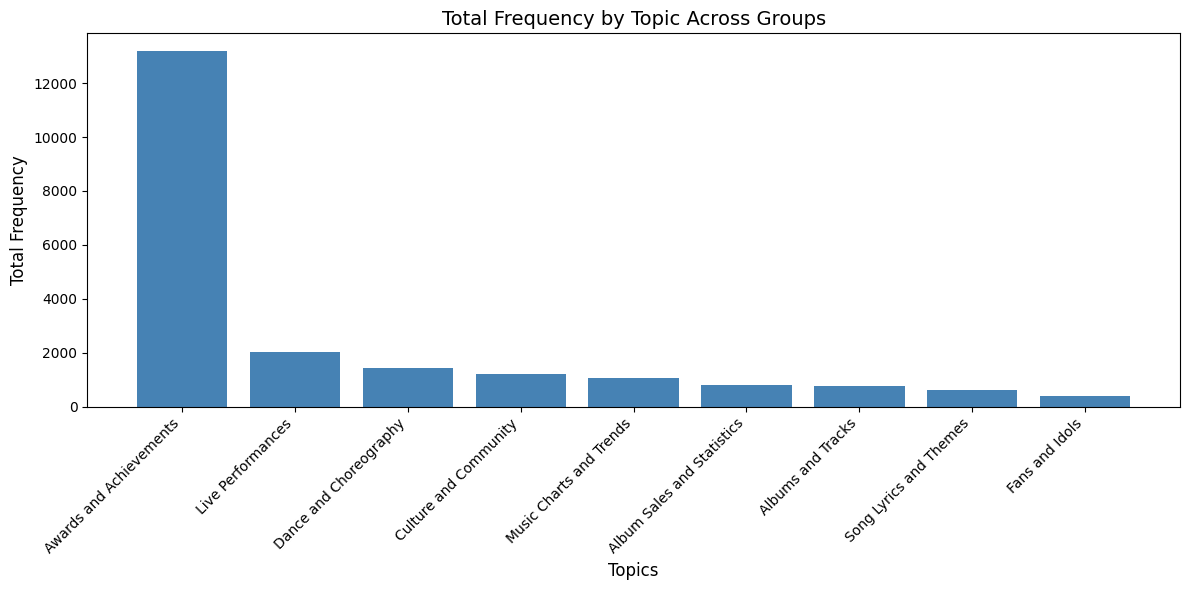

In [ ]:
topic_sum = all_topics_df.groupby("Topic Name")["Count"].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(topic_sum.index, topic_sum.values, color="steelblue")
plt.xlabel("Topics", fontsize=12)
plt.ylabel("Total Frequency", fontsize=12)
plt.title("Total Frequency by Topic Across Groups", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.show()

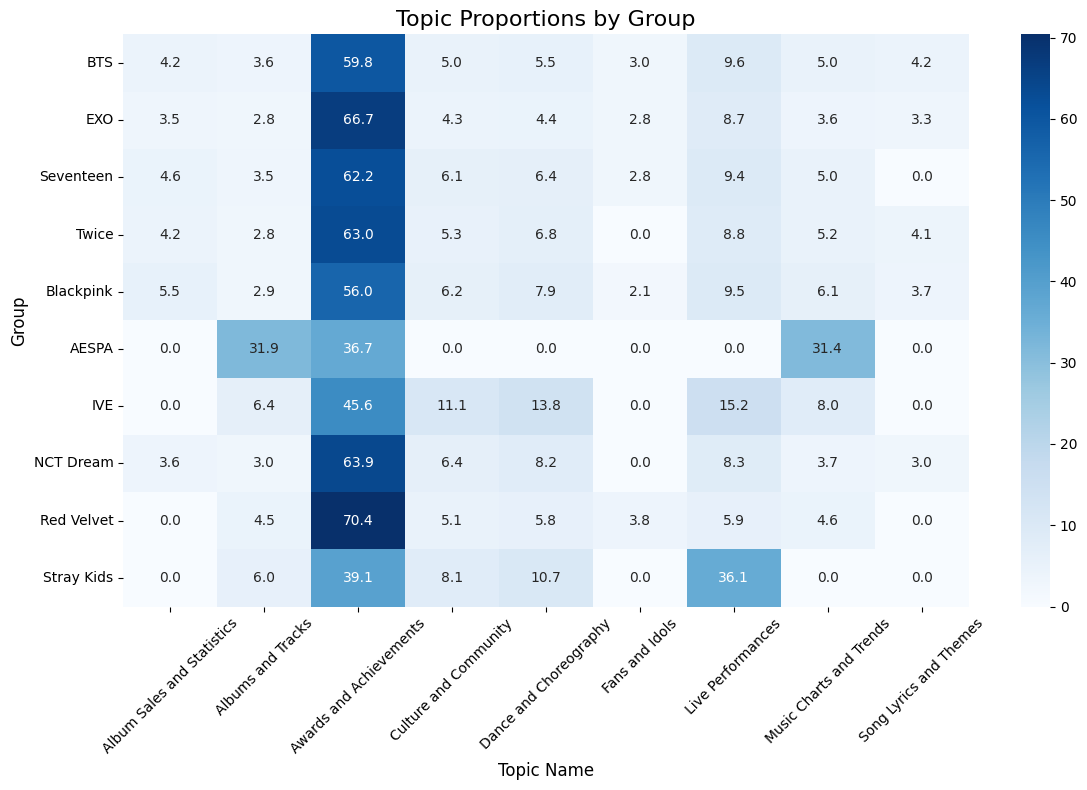

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    topic_percentage_table,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    cbar=True
)

plt.title("Topic Proportions by Group", fontsize=16)
plt.xlabel("Topic Name", fontsize=12)
plt.ylabel("Group", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

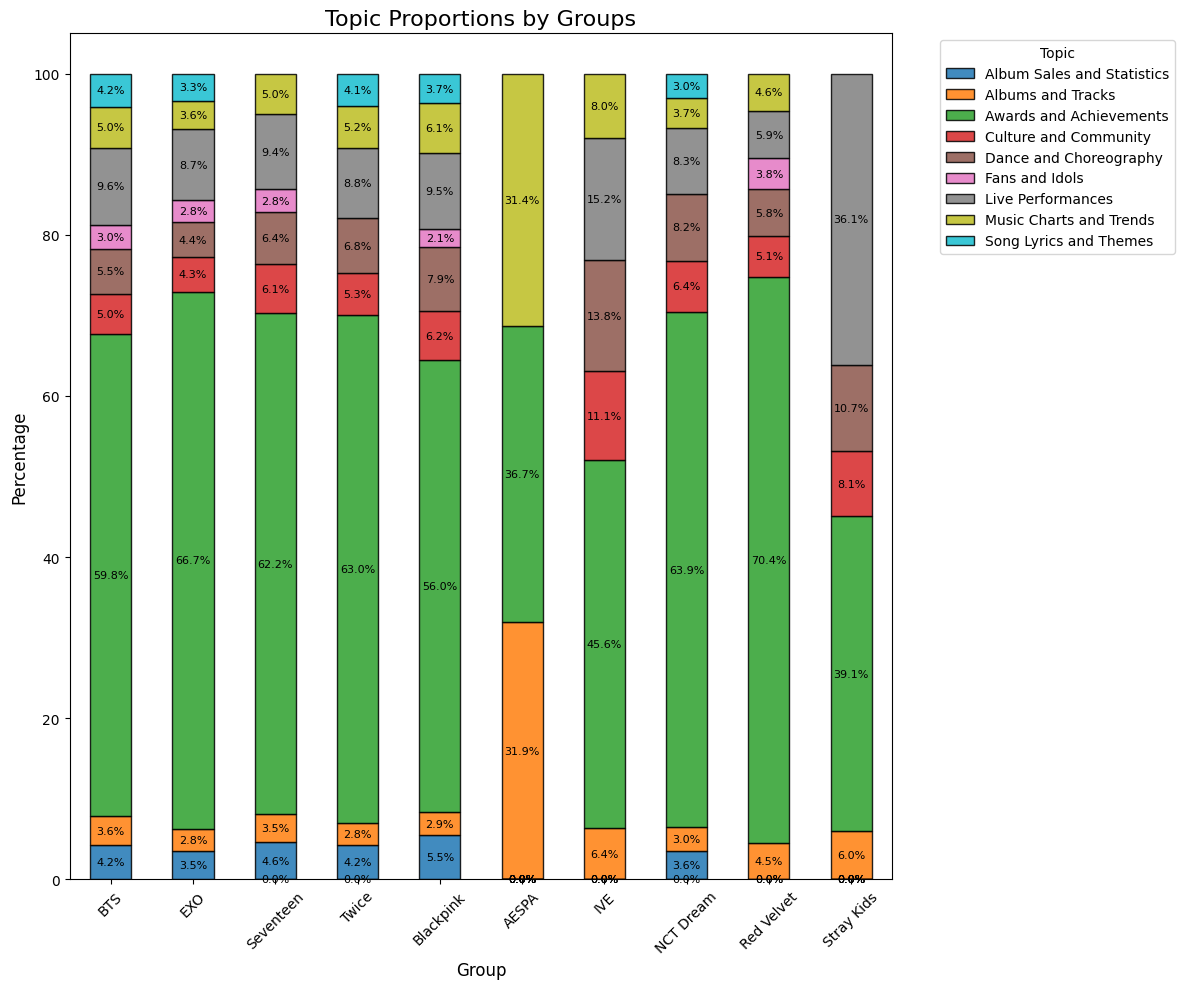

In [ ]:
group_percentage = (
    all_topics_df.groupby(["Group", "Topic Name"])["Count"]
    .sum()
    .unstack()
    .fillna(0)
)

group_percentage = group_percentage.div(group_percentage.sum(axis=1), axis=0) * 100

ax = group_percentage.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 10),
    colormap="tab10",
    alpha=0.85,
    edgecolor="black"
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=8, color="black")

plt.title("Topic Proportions by Groups", fontsize=16)
plt.xlabel("Group", fontsize=12)
plt.ylabel("Percentage", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

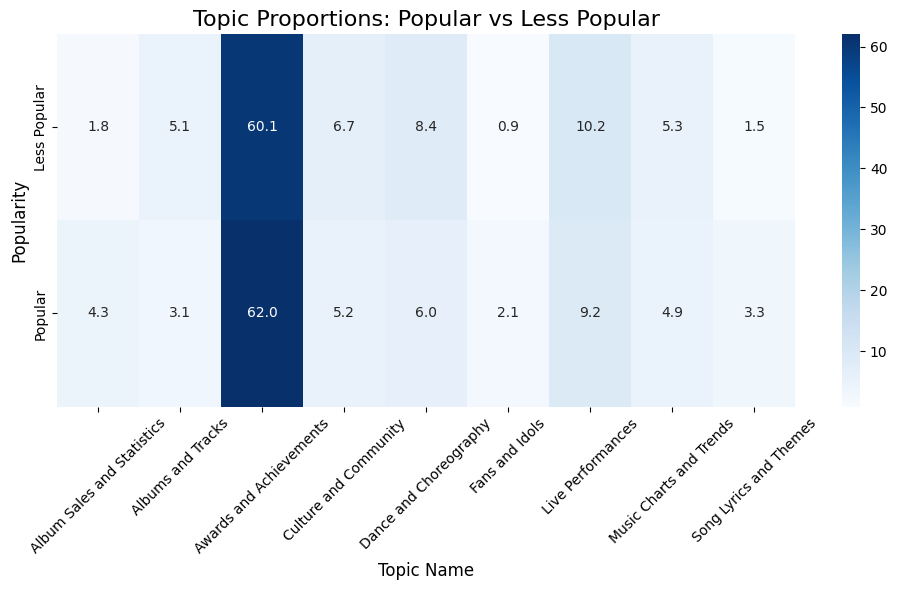

In [ ]:
popular_less_popular_table = (
    all_topics_df.groupby(["Popularity", "Topic Name"])["Count"]
    .sum()
    .unstack()
    .fillna(0)
)

popular_less_popular_percentage = popular_less_popular_table.div(popular_less_popular_table.sum(axis=1), axis=0) * 100
popular_less_popular_percentage = popular_less_popular_percentage.round(1)


plt.figure(figsize=(10, 6))
sns.heatmap(
    popular_less_popular_percentage,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    cbar=True
)

plt.title("Topic Proportions: Popular vs Less Popular", fontsize=16)
plt.xlabel("Topic Name", fontsize=12)
plt.ylabel("Popularity", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

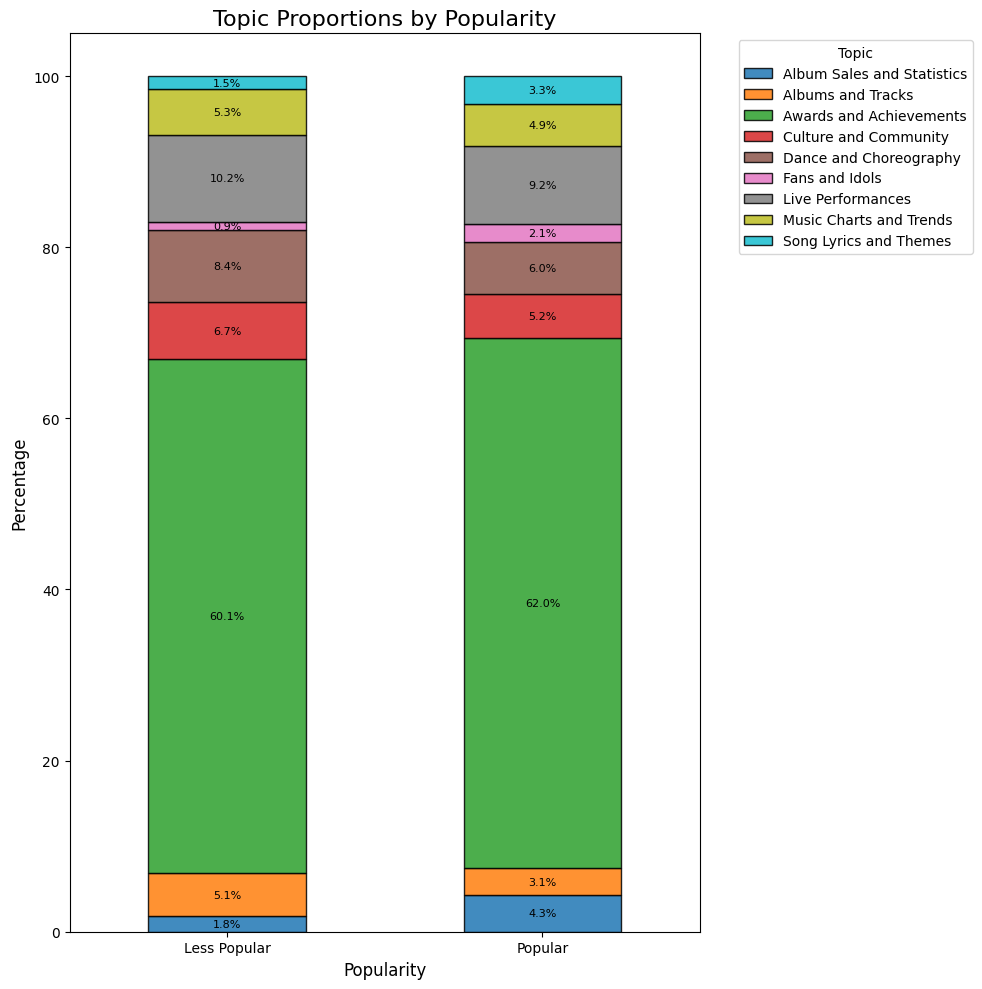

In [ ]:
popularity_percentage = (
    all_topics_df.groupby(["Popularity", "Topic Name"])["Count"]
    .sum()
    .unstack()
    .fillna(0)
)

popularity_percentage = popularity_percentage.div(popularity_percentage.sum(axis=1), axis=0) * 100


ax = popularity_percentage.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 10),
    colormap="tab10",
    alpha=0.85,
    edgecolor="black"
)


for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=8, color="black")


plt.title("Topic Proportions by Popularity", fontsize=16)
plt.xlabel("Popularity", fontsize=12)
plt.ylabel("Percentage", fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Topics Similarity and Dissimilarity

In [ ]:
groups = ['BTS', 'EXO', 'SVT', 'TWICE', 'BP', 'Aespa', 'IVE', 'NCT', 'RV', 'SKZ']

group_embeddings = {}
for group in groups:
    topics_info = globals()[f"{group.lower()}_topics_info"]  # fetch data based on the variable names
    group_embeddings[group] = embedding_model.encode([' '.join(words) for words in topics_info['Representation']])

In [ ]:
less_popular_embeddings = np.concatenate([group_embeddings['SKZ'], group_embeddings['NCT'], group_embeddings['IVE'], group_embeddings['Aespa'], group_embeddings['RV']])
popular_embeddings = np.concatenate([group_embeddings['BTS'], group_embeddings['BP'], group_embeddings['EXO'], group_embeddings['TWICE'], group_embeddings['SVT']])

less_popular_mean_embedding = np.mean(less_popular_embeddings, axis=0)
popular_mean_embedding = np.mean(popular_embeddings, axis=0)

popular_similarity = cosine_similarity([less_popular_mean_embedding, popular_mean_embedding])
popular_similarity[0][1]

0.99146026

In [ ]:
similarity_matrices = []
for i in range(len(groups)):
    for j in range(i + 1, len(groups)):
        sim_matrix = cosine_similarity(group_embeddings[groups[i]], group_embeddings[groups[j]])
        average_similarities = np.mean(sim_matrix, axis=1)
        overall_average_similarity = np.mean(average_similarities)
        similarity_matrices.append({
            'Group A': groups[i],
            'Group B': groups[j],
            'Average Similarity': overall_average_similarity
        })

similarity = pd.DataFrame(similarity_matrices)

In [ ]:
similarity

,Group A,Group B,Average Similarity
0,BTS,EXO,0.202313
1,BTS,SVT,0.214862
2,BTS,TWICE,0.198749
3,BTS,BP,0.209958
4,BTS,Aespa,0.239716
5,BTS,IVE,0.227738
6,BTS,NCT,0.198145
7,BTS,RV,0.215630
8,BTS,SKZ,0.244136
9,EXO,SVT,0.220924


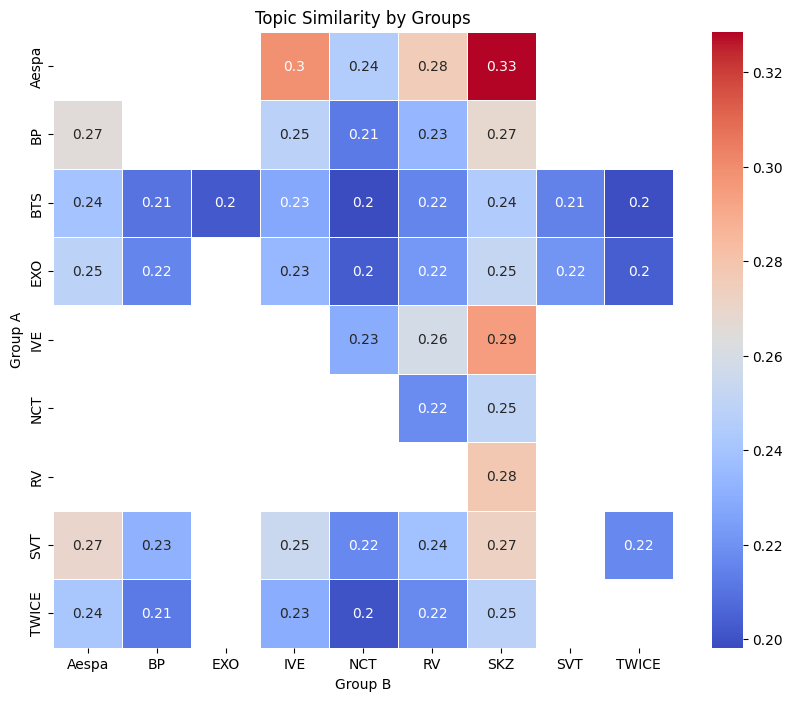

In [ ]:
pivot_table = similarity.pivot(index="Group A", columns="Group B", values="Average Similarity")

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap="coolwarm", linewidths=.5)
plt.title('Topic Similarity by Groups')
plt.show()

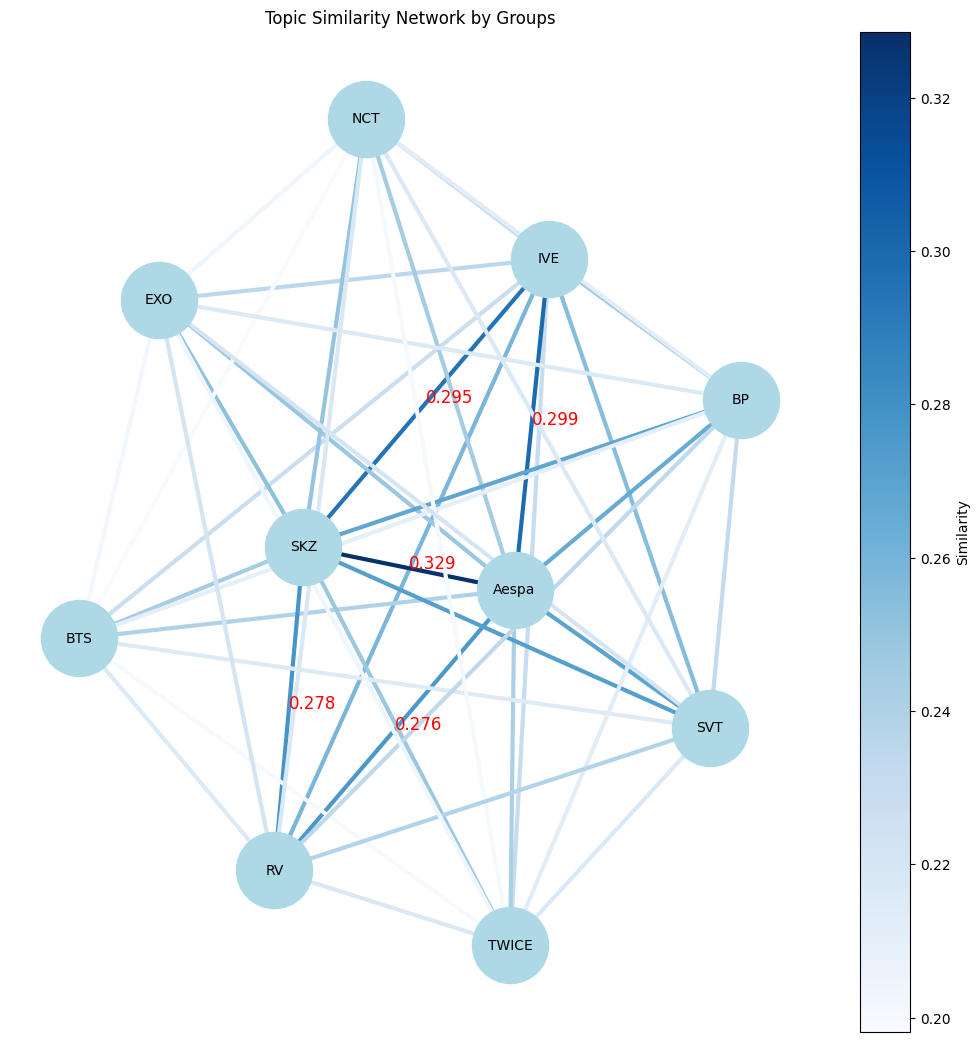

In [ ]:
import networkx as nx
G = nx.Graph()

groups = set(similarity['Group A']).union(set(similarity['Group B']))
G.add_nodes_from(groups)

for index, row in similarity.iterrows():
    G.add_edge(row['Group A'], row['Group B'], weight=row['Average Similarity'])

pos = nx.spring_layout(G, seed=42)

edges = G.edges(data=True)
weights = [edge[2]['weight'] for edge in edges]

norm = plt.Normalize(min(weights), max(weights))
cmap = plt.cm.Blues
edge_colors = [cmap(norm(weight)) for weight in weights]

plt.figure(figsize=(10, 10))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=10,
        edge_color=edge_colors, width=3, edge_cmap=cmap)

sorted_edges = sorted(edges, key=lambda x: x[2]['weight'], reverse=True)[:5]
for edge in sorted_edges:
    node1, node2, data = edge
    x1, y1 = pos[node1]
    x2, y2 = pos[node2]
    mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
    plt.text(mid_x, mid_y, f"{data['weight']:.3f}", fontsize=12, color='red')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=plt.gca(),label='Similarity')

plt.title('Topic Similarity Network by Groups')
plt.show()

# Topics over time

In [ ]:
group_topic_model = {
    "Stray Kids": skz_topic_model,
    "EXO": exo_topic_model,
    "Seventeen": svt_topic_model,
    "Twice": twice_topic_model,
    "Blackpink": bp_topic_model,
    "AESPA": aespa_topic_model,
    "IVE": ive_topic_model,
    "NCT Dream": nct_topic_model,
    "Red Velvet": rv_topic_model,
    "BTS": bts_topic_model
}

for group, topic_model in group_topic_model.items():
    document_info = topic_model.get_document_info(documents_per_group[group])
    document_info['Topic Number'] = topic_mapping(document_info['Name'])
    document_info['Topic Name'] = document_info['Topic Number'].apply(lambda x: topic_list[int(x)] if pd.notna(x) and x.is_integer() else None)
    group_filtered_incl_comments[group]['topic'] = document_info['Topic Name'].values
    group_filtered_incl_comments[group]['year'] = pd.to_datetime( group_filtered_incl_comments[group]['date']).dt.year

In [ ]:
group_filtered_incl_comments['Stray Kids'].head()

,id,title,body,num_comments,score,comments,date,matching_group_incl_comments,matching_group_excl_comments,topic,year
6389,7m0e05,kpop monday qampa ask december 25 2017,kpop question need answered ask away rules top...,70,20,"[happening ladies code gon na active hope, 1 w...",2017-12-25,"[BTS, EXO, Seventeen, Twice, Bangtan, BP, stra...",[],Awards and Achievements,2017
6477,7p2ssr,spotlight stray kids,# # brief introduction context index stray kid...,34,160,[thank stupidly huge heart want love possible ...,2018-01-08,"[BTS, Seventeen, Twice, straykids]","[BTS, Twice, straykids]",Album Sales and Statistics,2018
6865,86j1eq,kpop friday freeforall march 23 2018,goes mean previous ffa threads,142,30,[recently phone started replacing time extreme...,2018-03-23,"[Seventeen, Twice, Blackpink, straykids]",[],Awards and Achievements,2018
6881,87gyx7,stray kids district 9 breaks record views 24 h...,screenshot mv previous record held wanna ones ...,72,489,"[mods saw soompi posted article delete post, t...",2018-03-27,"[BTS, EXO, Twice, BP, RV, straykids]",[],Album Sales and Statistics,2018
7149,8obeqw,idols favourite singing voice rapping voice sp...,singing jonghyun rapping taeyong speaking momo,253,177,[singingspeaking kim taehyung gives chills dam...,2018-06-03,"[BTS, EXO, Seventeen, Twice, Blackpink, BP, Dr...",[],Dance and Choreography,2018


In [ ]:
topic_colors = {
    "Awards and Achievements": "blue",
    "Groups and Members": "orange",
    "Live Performances": "green",
    "Dance and Choreography": "red",
    "Culture and Community": "purple",
    "Music Charts and Trends": "brown",
    "Album Sales and Statistics": "pink",
    "Entertainment Companies, Debuts and Comeback": "gray",
    "Song Lyrics and Themes": "cyan",
    "Albums and Tracks": "magenta",
    "K-pop Songs": "olive",
    "Fans and Idols": "teal",
    "General K-pop Discussions": "lime",
    "Listening Experiences": "coral",
    "Vocals and Rap Skills": "salmon"
}

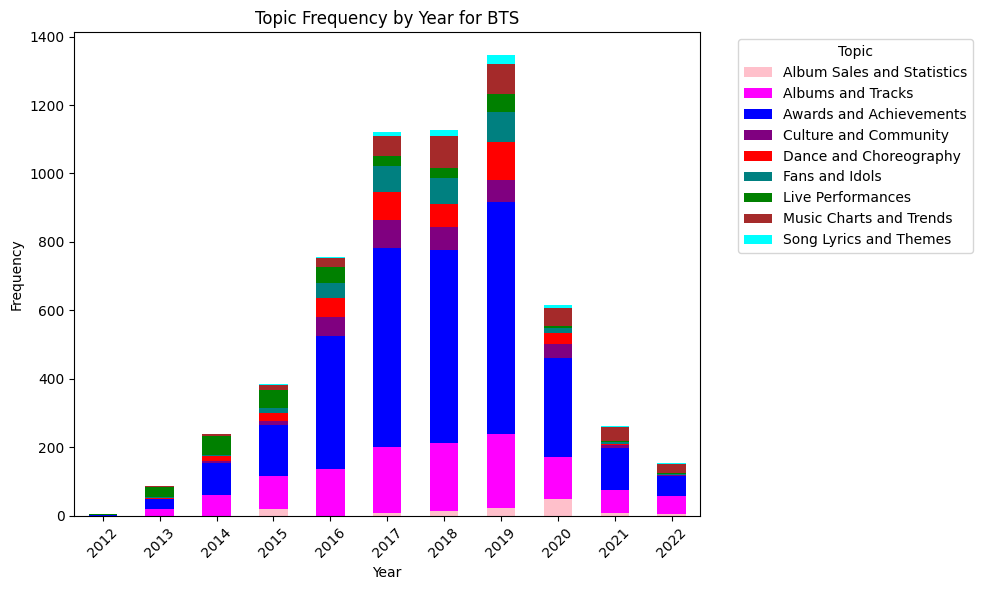

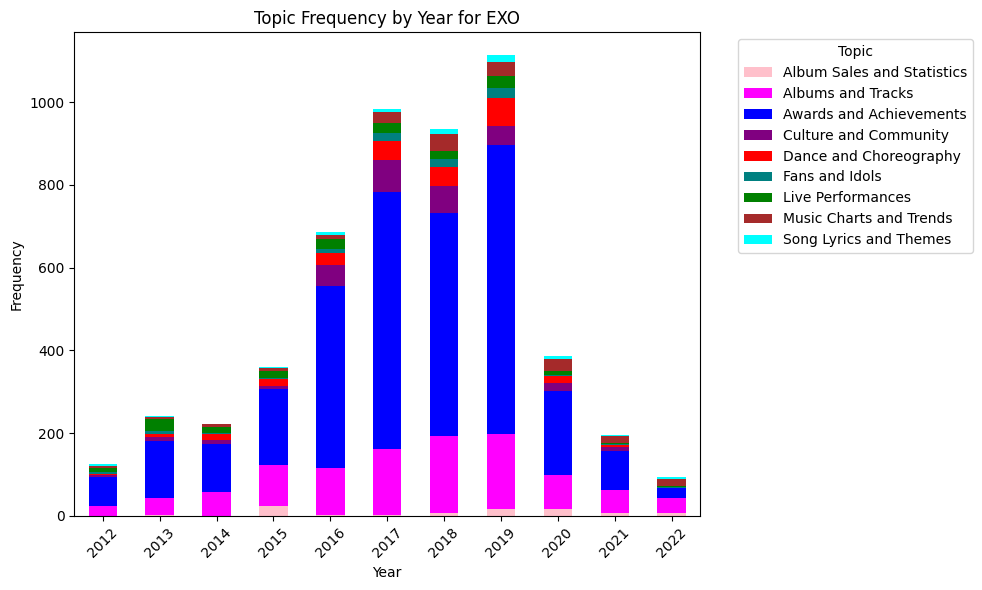

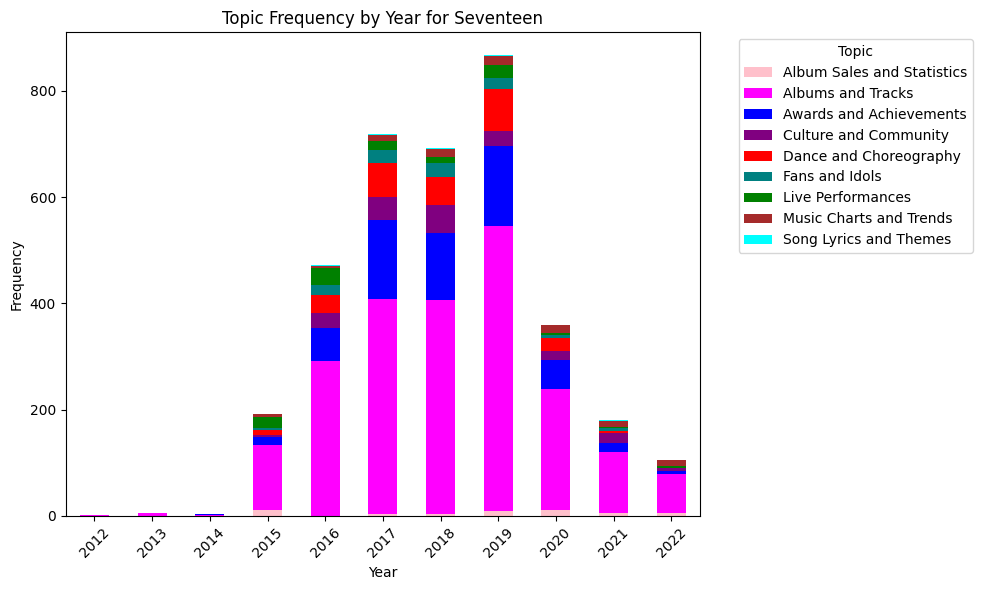

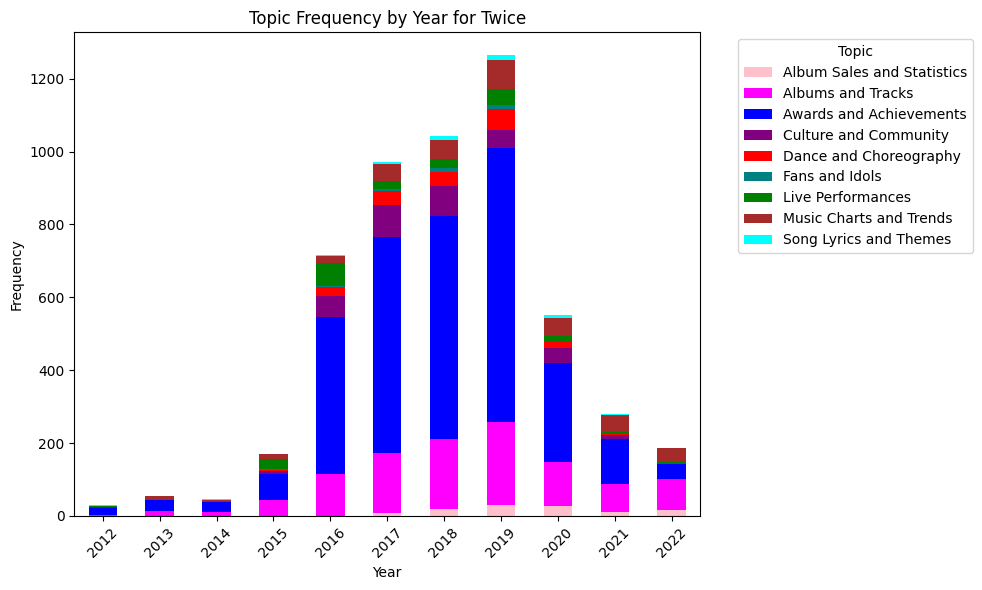

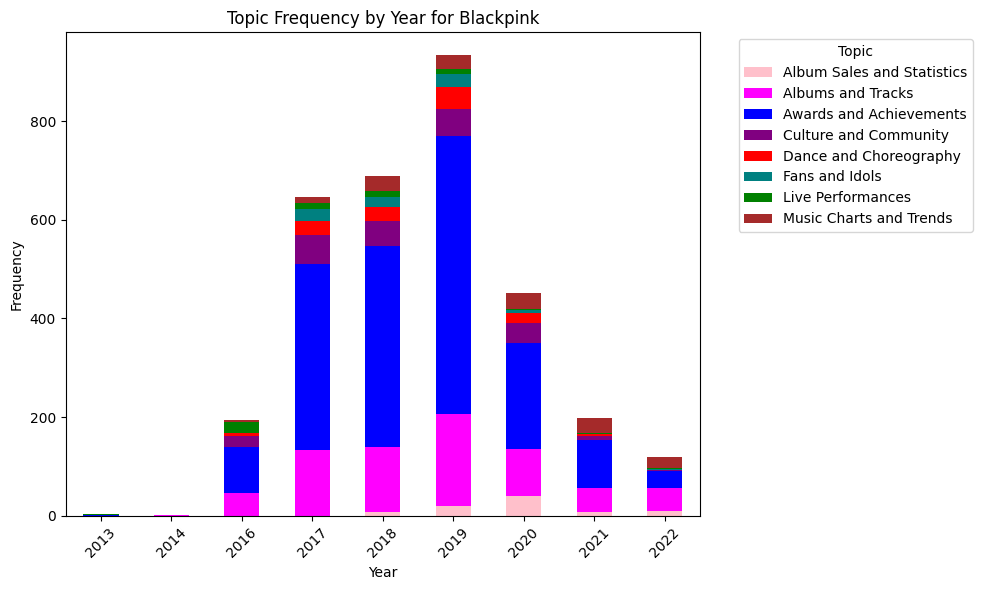

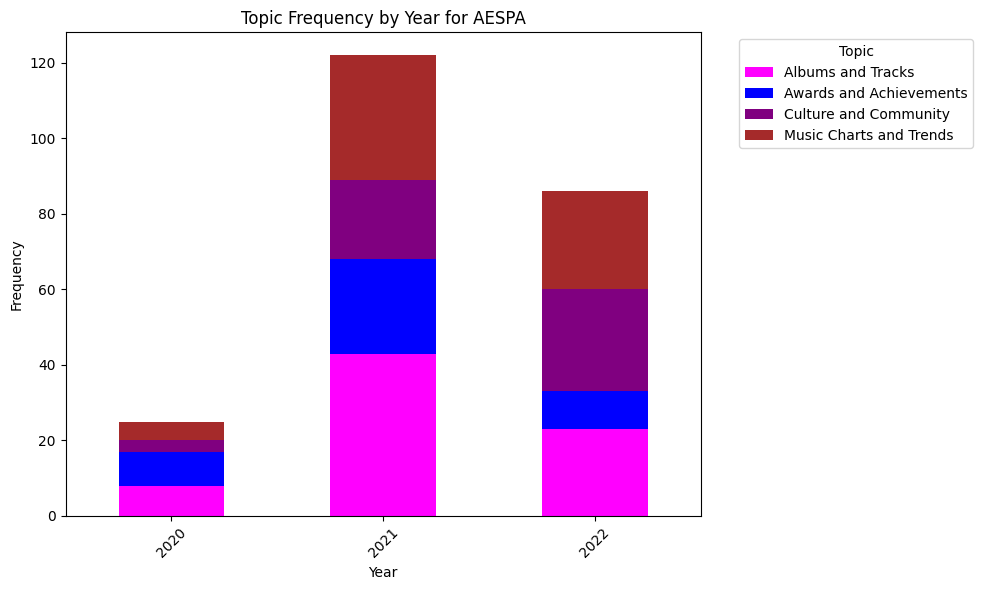

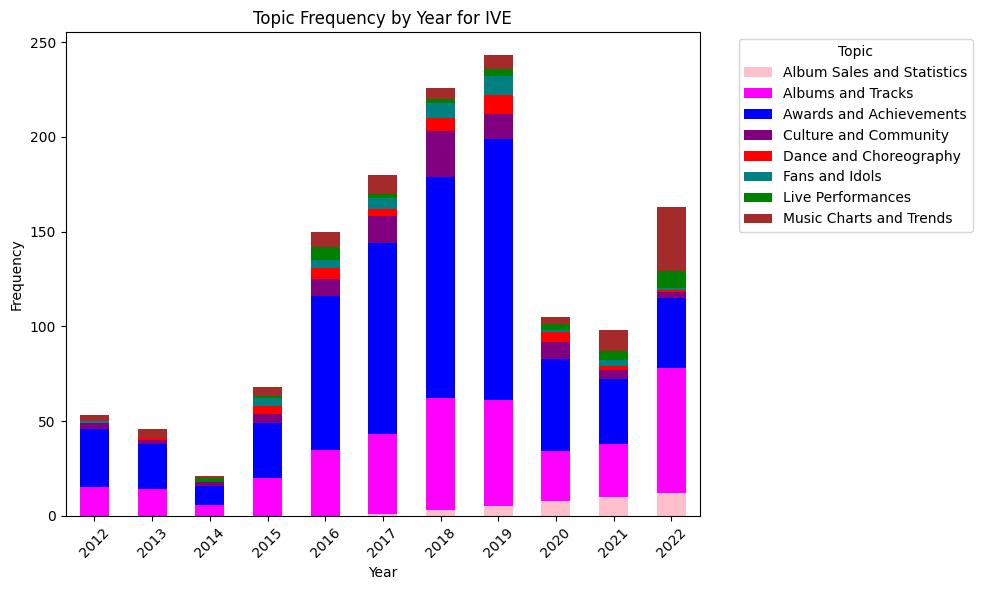

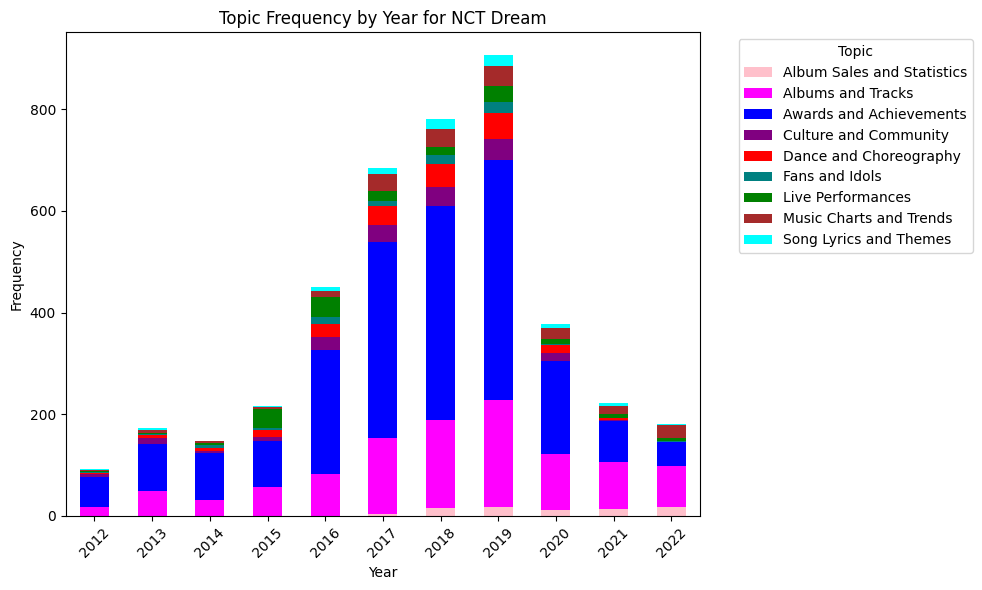

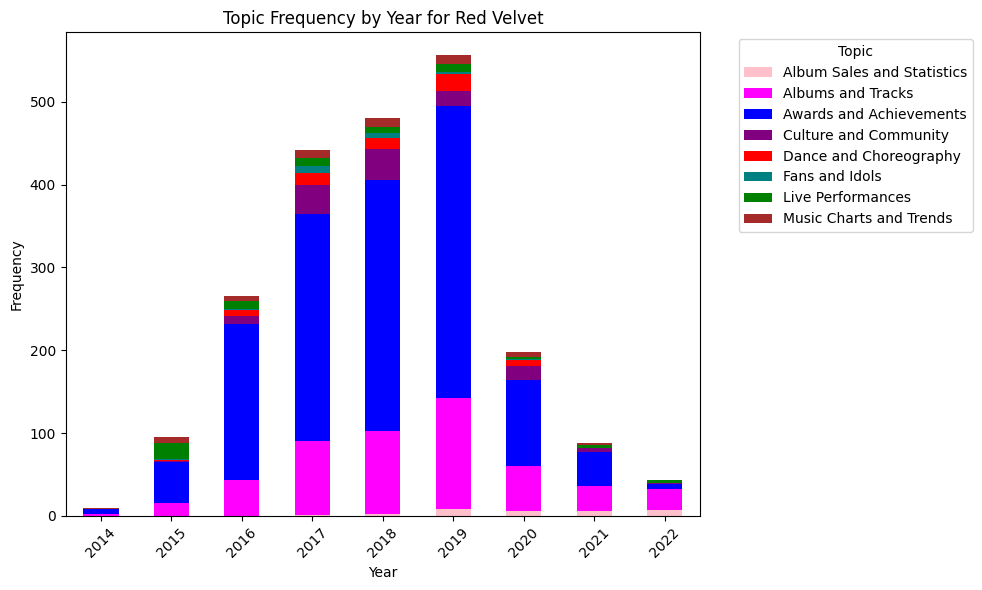

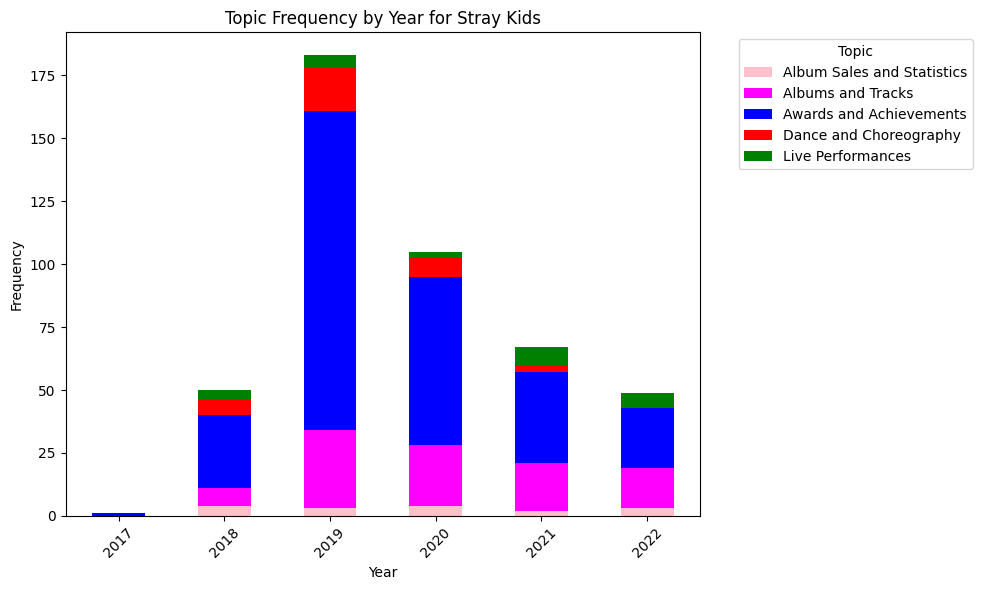

In [ ]:
for group in group_names_dict.keys():
    topic_counts = group_filtered_incl_comments[group].groupby(['year', 'topic']).size().unstack(fill_value=0)
    topic_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=[topic_colors[topic] for topic in topic_counts.columns])

    plt.title(f'Topic Frequency by Year for {group}')
    plt.xlabel('Year')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

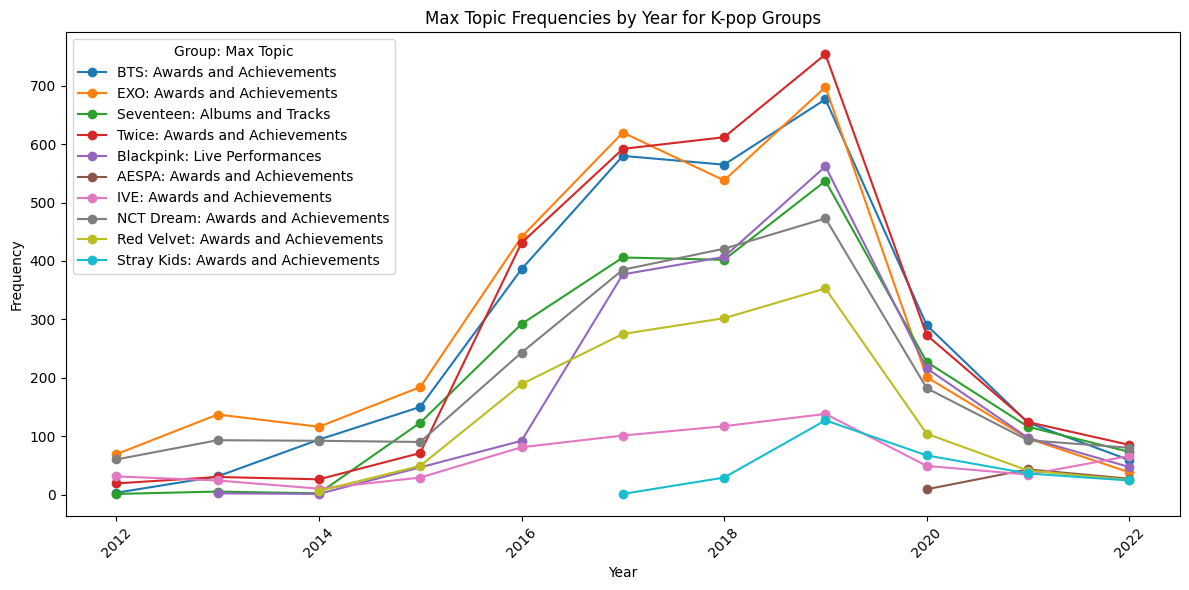

In [ ]:
max_topic_counts = pd.DataFrame(columns=['Group', 'Year', 'Max Topic', 'Max Frequency'])

for group in group_names_dict.keys():
    topic_counts = group_filtered_incl_comments[group].groupby(['year', 'topic']).size().unstack(fill_value=0)

    for year in topic_counts.index:
        max_topic = topic_counts.loc[year].idxmax()
        max_frequency = topic_counts.loc[year].max()

        max_topic_counts = pd.concat([max_topic_counts, pd.DataFrame({
            'Group': group,
            'Year': year,
            'Max Topic': max_topic,
            'Max Frequency': max_frequency
        }, index=[0])], ignore_index=True)

plt.figure(figsize=(12, 6))

for group in max_topic_counts['Group'].unique():
    group_data = max_topic_counts[max_topic_counts['Group'] == group]
    plt.plot(group_data['Year'], group_data['Max Frequency'], marker='o', label=f'{group}: {group_data["Max Topic"].values[0]}')

plt.title('Max Topic Frequencies by Year for K-pop Groups')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend(title='Group: Max Topic')
plt.tight_layout()
plt.show()

In [ ]:
popular_groups = ['BTS', 'Blackpink', 'EXO', 'Seventeen', 'Twice']
less_popular_groups = ['NCT Dream', 'Stray Kids', 'IVE', 'Red Velvet', 'AESPA']

def sum_topic_counts(groups):
    combined_df = pd.concat([group_filtered_incl_comments[group] for group in groups], ignore_index=True)
    combined_counts = combined_df.groupby(['year', 'topic']).size().unstack(fill_value=0)
    return combined_counts

popular_topic_counts = sum_topic_counts(popular_groups)
less_popular_topic_counts = sum_topic_counts(less_popular_groups)

popular_topic_ratios = popular_topic_counts.div(popular_topic_counts.sum(axis=1), axis=0)
less_popular_topic_ratios = less_popular_topic_counts.div(less_popular_topic_counts.sum(axis=1), axis=0)

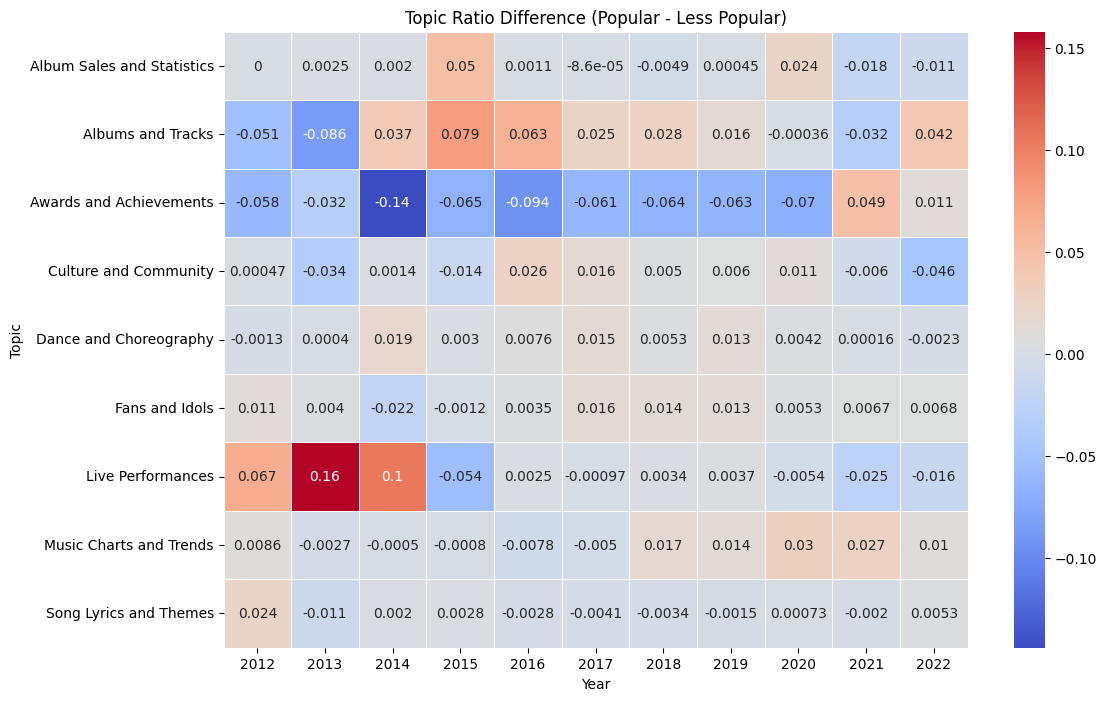

In [ ]:
topic_difference = popular_topic_ratios - less_popular_topic_ratios

plt.figure(figsize=(12, 8))
sns.heatmap(topic_difference.T, cmap="coolwarm", annot=True, cbar=True, linewidths=.5)
plt.title('Topic Ratio Difference (Popular - Less Popular)')
plt.xlabel('Year')
plt.ylabel('Topic')
plt.show()